In [1]:
! nvidia-smi

Fri Dec 30 09:31:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.43.04    Driver Version: 515.43.04    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  Off |
|  0%   23C    P8    17W / 480W |    658MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os

class Config:
    AUTHOR = "shu421"

    EXP = "exp001"
    MODEL_PATH = 'microsoft/deberta-v3-base'
    DATASET_PATH = []

    COMPETITION = "learning-equality-curriculum-recommendations"

    BASE_PATH = '/home/working/'

    api_path = "/.kaggle/kaggle.json"

    apex=True
    seed = 42
    num_fold = 5
    trn_fold = [0, 1, 2, 3, 4,]
    batch_size = 8
    n_epochs = 5
    max_len = 1024
    target_list = ["cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"]
    
    weight_decay = 0.01
    scheduler='cosine'
    betas = (0.9, 0.999)
    encoder_lr = 2e-5
    decoder_lr = 2e-5
    lr_weight_decay = 0.95
    
    min_lr = 1e-6
    eps = 1e-6
    eval_step = 40
    num_cycles=0.5
    num_warmup_steps_rate=0.1
    clip_grad_norm = 1000
    gradient_accumulation_steps = 1

    # weight and bias
    wandb = False
    
    # GPU Optimize Settings
    gpu_optimize_config= {
        "freezing": False,
        "gradient_checkpoint": True
    }

    upload_from_colab = True

In [3]:
import os
import re
import gc
import pdb
import sys
import json
import time
import shutil
import joblib
import random
import requests
import warnings
warnings.filterwarnings('ignore')
from ast import literal_eval
from tqdm.auto import tqdm
from pathlib import Path
from glob import glob
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

import numpy as np
import pandas as pd
import scipy 
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('ggplot')
# sns.set()
from sklearn.model_selection import (
    StratifiedKFold, 
    KFold, 
    GroupKFold,
    StratifiedGroupKFold
)
from sklearn.metrics import mean_squared_error

# ! pip install iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.checkpoint import checkpoint
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F


from kaggle.api.kaggle_api_extended import KaggleApi

import transformers
from transformers import AutoConfig, AutoModel, AutoTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
import tokenizers
import sentencepiece
from transformers import logging
logging.set_verbosity_warning()
logging.set_verbosity_error()
%env TOKENIZERS_PARALLELISM=true


INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.

In [6]:
# ====================================================
# wandb
# ====================================================
if Config.wandb:
    
    import wandb
    import json

    try:
        # from kaggle_secrets import UserSecretsClient
        # user_secrets = UserSecretsClient()
        # secret_value_0 = user_secrets.get_secret("wandb_api")
        wandb_config = json.load(open('/root/.kaggle/wandb.json', 'rb'))
        secret_value_0 = wandb_config['key']
        wandb.login(key=secret_value_0)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    run = wandb.init(project=Config.COMPETITION, 
                     name=Config.EXP,
                     config=class2dict(Config),
                     group=Config.MODEL_PATH,
                     job_type="train",
                     anonymous=anony)

In [7]:
def setup(cfg):
    # cfg.COLAB = 'google.colab' in sys.modules
    cfg.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # use kaggle api (need kaggle token)
    f = open(cfg.api_path, 'r')
    json_data = json.load(f) 
    os.environ['KAGGLE_USERNAME'] = json_data['username']
    os.environ['KAGGLE_KEY'] = json_data['key']

    # set dirs
    # cfg.DRIVE = cfg.DRIVE_PATH
    # cfg.EXP = (cfg.NAME if cfg.NAME is not None 
    #     else requests.get('http://172.28.0.2:9000/api/sessions').json()[0]['name'][:-6]
    # )
    cfg.INPUT = os.path.join(cfg.BASE_PATH, 'input')
    cfg.OUTPUT = os.path.join(cfg.BASE_PATH, 'output')
    cfg.SUBMISSION = os.path.join(cfg.BASE_PATH, 'submission')
    cfg.DATASET = os.path.join(cfg.BASE_PATH, 'dataset')

    cfg.OUTPUT_EXP = os.path.join(cfg.OUTPUT, cfg.EXP) 
    cfg.EXP_MODEL = os.path.join(cfg.OUTPUT_EXP, 'model')
    cfg.EXP_FIG = os.path.join(cfg.OUTPUT_EXP, 'fig')
    cfg.EXP_PREDS = os.path.join(cfg.OUTPUT_EXP, 'preds')

    # make dirs
    for d in [cfg.INPUT, cfg.SUBMISSION, cfg.EXP_MODEL, cfg.EXP_FIG, cfg.EXP_PREDS]:
        os.makedirs(d, exist_ok=True)
    
    # if not os.path.isfile(os.path.join(cfg.INPUT, 'train.csv')):
    if len(os.listdir(cfg.INPUT))==0:
        # load dataset
        !kaggle competitions download -c $cfg.COMPETITION -p $cfg.INPUT
        filepath = os.path.join(cfg.INPUT,cfg.COMPETITION+'.zip')
        !unzip -d $cfg.INPUT $filepath
        
    
    for path in cfg.DATASET_PATH:
        datasetpath = os.path.join(cfg.DATASET,  path.split('/')[1])
        if not os.path.exists(datasetpath):
            os.makedirs(datasetpath, exist_ok=True)
            !kaggle datasets download $path -p $datasetpath
            filepath = os.path.join(datasetpath, path.split("/")[1]+'.zip')
            !unzip -d $datasetpath $filepath
    return cfg


def dataset_create_new(dataset_name, upload_dir):
    dataset_metadata = {}
    dataset_metadata['id'] = f'{os.environ["KAGGLE_USERNAME"]}/{dataset_name}'
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = dataset_name
    with open(os.path.join(upload_dir, 'dataset-metadata.json'), 'w') as f:
        json.dump(dataset_metadata, f, indent=4)
    api = KaggleApi()
    api.authenticate()
    api.dataset_create_new(folder=upload_dir, convert_to_csv=False, dir_mode='tar')

In [8]:
# =====================
# Utils
# =====================
# Seed
def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# KFold
def get_kfold(train, n_splits, seed):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    generator = kf.split(train)
    fold_series = []
    for fold, (idx_train, idx_valid) in enumerate(generator):
        fold_series.append(pd.Series(fold, index=idx_valid))
    fold_series = pd.concat(fold_series).sort_index()
    return fold_series

def get_stratifiedkfold(train, target_col, n_splits, seed):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    generator = kf.split(train, train[target_col])
    fold_series = []
    for fold, (idx_train, idx_valid) in enumerate(generator):
        fold_series.append(pd.Series(fold, index=idx_valid))
    fold_series = pd.concat(fold_series).sort_index()
    return fold_series

def get_groupkfold(train, target_col, group_col, n_splits):
    kf = GroupKFold(n_splits=n_splits)
    generator = kf.split(train, train[target_col], train[group_col])
    fold_series = []
    for fold, (idx_train, idx_valid) in enumerate(generator):
        fold_series.append(pd.Series(fold, index=idx_valid))
    fold_series = pd.concat(fold_series).sort_index()
    return fold_series

def get_groupstratifiedkfold(train, target_col, group_col, n_splits, seed):
    kf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    generator = kf.split(train, train[target_col], train[group_col])
    fold_series = []
    for fold, (idx_train, idx_valid) in enumerate(generator):
        fold_series.append(pd.Series(fold, index=idx_valid))
    fold_series = pd.concat(fold_series).sort_index()
    return fold_series

def get_multilabelstratifiedkfold(train, target_col, n_splits, seed):
    kf = MultilabelStratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    generator = kf.split(train, train[target_col])
    fold_series = []
    for fold, (idx_train, idx_valid) in enumerate(generator):
        fold_series.append(pd.Series(fold, index=idx_valid))
    fold_series = pd.concat(fold_series).sort_index()
    return fold_series

In [9]:
def mcrmse(cfg, preds, df):
    all_score = 0
    for i, column in enumerate(cfg.target_list):
        score = np.sqrt(mean_squared_error(preds[:, i], df[column]))
        all_score += score/len(cfg.target_list)
    return all_score

def get_logger(filename):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

In [10]:
# 文章のバグを治す
from text_unidecode import unidecode
from typing import Dict, List, Tuple
import codecs

def replace_encoding_with_utf8(error: UnicodeError) -> Tuple[bytes, int]:
    return error.object[error.start : error.end].encode("utf-8"), error.end


def replace_decoding_with_cp1252(error: UnicodeError) -> Tuple[str, int]:
    return error.object[error.start : error.end].decode("cp1252"), error.end

# Register the encoding and decoding error handlers for `utf-8` and `cp1252`.
codecs.register_error("replace_encoding_with_utf8", replace_encoding_with_utf8)
codecs.register_error("replace_decoding_with_cp1252", replace_decoding_with_cp1252)

def resolve_encodings_and_normalize(text: str) -> str:
    """Resolve the encoding problems and normalize the abnormal characters."""
    text = (
        text.encode("raw_unicode_escape")
        .decode("utf-8", errors="replace_decoding_with_cp1252")
        .encode("cp1252", errors="replace_encoding_with_utf8")
        .decode("utf-8", errors="replace_decoding_with_cp1252")
    )
    text = unidecode(text)
    return text

In [11]:
# =====================
# Dataset, Model
# =====================

def processing_features(df):
    df['text'] = df['full_text'].apply(lambda x : resolve_encodings_and_normalize(x))
    return df

# dataset
class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.text = df['text'].to_numpy()
        self.labels = df[cfg.target_list].to_numpy()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        inputs = self.prepare_input(self.cfg, self.text[index])
        label = torch.tensor(self.labels[index], dtype=torch.float)
        return inputs, label

    @staticmethod
    def prepare_input(cfg, text):
        inputs = cfg.tokenizer(text,
                               add_special_tokens=True,
                               max_length=cfg.max_len,
                               padding="max_length",
                               truncation=True,
                               return_offsets_mapping=False)
        inputs['input_ids'] = torch.tensor(
            inputs['input_ids'],
            dtype=torch.long
        )
        inputs['attention_mask'] = torch.tensor(
            inputs['attention_mask'],
            dtype=torch.long
        )
        inputs = {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
        }
        return inputs

def collate(inputs):
    mask_len = int(inputs["attention_mask"].sum(axis=1).max())
    for k, v in inputs.items():
        inputs[k] = inputs[k][:,:mask_len]
    return inputs

In [12]:
def freeze(module):
    """
    Freezes module's parameters.
    """
    
    for parameter in module.parameters():
        parameter.requires_grad = False

class AttentionPooling(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.attention = nn.Sequential(
        nn.Linear(in_dim, in_dim),
        nn.LayerNorm(in_dim),
        nn.GELU(),
        nn.Linear(in_dim, 1),
        )
        
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def forward(self, last_hidden_state, attention_mask):
        w = self.attention(last_hidden_state).float()
        w[attention_mask==0]=float('-inf')
        w = torch.softmax(w,1)
        attention_embeddings = torch.sum(w * last_hidden_state, dim=1)
        return attention_embeddings

class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min = 1e-9)
        mean_embeddings = sum_embeddings/sum_mask
        return mean_embeddings
        

class WeightedLayerPooling(nn.Module):
    def __init__(self, num_hidden_layers, layer_start: int = 4, layer_weights = None):
        super(WeightedLayerPooling, self).__init__()
        self.layer_start = layer_start
        self.num_hidden_layers = num_hidden_layers
        self.layer_weights = layer_weights if layer_weights is not None \
            else nn.Parameter(
                torch.tensor([1] * (num_hidden_layers+1 - layer_start), dtype=torch.float)
            )

    def forward(self, ft_all_layers):
        all_layer_embedding = torch.stack(ft_all_layers)
        all_layer_embedding = all_layer_embedding[self.layer_start:, :, :, :]

        weight_factor = self.layer_weights.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).expand(all_layer_embedding.size())
        weighted_average = (weight_factor*all_layer_embedding).sum(dim=0) / self.layer_weights.sum()

        return weighted_average

class CustomModel(nn.Module):
    def __init__(self, cfg): 
        super().__init__()
        self.cfg = cfg
        self.gpu_optimize_config = cfg.gpu_optimize_config
        self.config = AutoConfig.from_pretrained(
            cfg.MODEL_PATH,
            output_hidden_states=True
        )
        self.config.update(
            {
                "output_hidden_states": True,
                "hidden_dropout": 0.,
                "hidden_dropout_prob": 0.,
                "attention_dropout": 0.,
                "attention_probs_dropout_prob": 0,
            }
        )
        self.model = AutoModel.from_pretrained(
            cfg.MODEL_PATH,
            config=self.config
        )
        self.pool = AttentionPooling(self.config.hidden_size)
        # self.weighted_layer_pool = WeightedLayerPooling(self.config.num_hidden_layers)
        # self.pool = MeanPooling()
        self.fc = nn.Linear(self.config.hidden_size, 6)
        self._init_weights(self.fc)
        self.ln = nn.LayerNorm(self.config.hidden_size)
        self._init_weights(self.ln)

        self.drop1 = nn.Dropout(0.1)
        self.drop2 = nn.Dropout(0.2)
        self.drop3 = nn.Dropout(0.3)
        self.drop4 = nn.Dropout(0.4)
        self.drop5 = nn.Dropout(0.5)

        # Freeze
        if self.gpu_optimize_config['freezing']:
            freeze(self.model.encoder.layer[:4])

        # Gradient Checkpointing
        if self.gpu_optimize_config['gradient_checkpoint']:
            self.model.gradient_checkpointing_enable()

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_state = outputs[0]
        feature = self.pool(last_state, inputs['attention_mask'])
        # all_layer_embeddings = outputs[1]
        # feature = self.weighted_layer_pool(all_layer_embeddings)
        # feature = self.pool(feature, inputs['attention_mask'])
        return feature

    def forward(self, inputs, labels):
        # batch, hidden_size
        feature = self.feature(inputs)
        feature = self.ln(feature)
        # feature1 = self.drop1(feature)
        # feature2 = self.drop2(feature)
        # feature3 = self.drop3(feature)
        # feature4 = self.drop4(feature)
        # feature5 = self.drop5(feature)
        # feature = (feature1 + feature2 + feature3 + feature4 + feature5) / 5
        output = self.fc(feature)

        if labels is not None:
            loss_fct = nn.SmoothL1Loss(reduction='mean')
            loss = loss_fct(output, labels)
            return loss, output
        else:
            return output

import math
from torch.autograd.function import InplaceFunction
from torch.nn import Parameter
import torch.nn.init as init
class Mixout(InplaceFunction):
    @staticmethod
    def _make_noise(input):
        return input.new().resize_as_(input)
    @classmethod
    def forward(cls, ctx, input, target=None, p=0.0, training=False, inplace=False):
        if p < 0 or p > 1:
            raise ValueError("A mix probability of mixout has to be between 0 and 1," " but got {}".format(p))
        if target is not None and input.size() != target.size():
            raise ValueError(
                "A target tensor size must match with a input tensor size {},"
                " but got {}".format(input.size(), target.size())
            )
        ctx.p = p
        ctx.training = training
        if ctx.p == 0 or not ctx.training:
            return input
        if target is None:
            target = cls._make_noise(input)
            target.fill_(0)
        target = target.to(input.device)
        if inplace:
            ctx.mark_dirty(input)
            output = input
        else:
            output = input.clone()
        ctx.noise = cls._make_noise(input)
        if len(ctx.noise.size()) == 1:
            ctx.noise.bernoulli_(1 - ctx.p)
        else:
            ctx.noise[0].bernoulli_(1 - ctx.p)
            ctx.noise = ctx.noise[0].repeat(input.size()[0], 1)
        ctx.noise.expand_as(input)
        if ctx.p == 1:
            output = target
        else:
            output = ((1 - ctx.noise) * target + ctx.noise * output - ctx.p * target) / (1 - ctx.p)
        return output
    @staticmethod
    def backward(ctx, grad_output):
        if ctx.p > 0 and ctx.training:
            return grad_output * ctx.noise, None, None, None, None
        else:
            return grad_output, None, None, None, None
def mixout(input, target=None, p=0.0, training=False, inplace=False):
    return Mixout.apply(input, target, p, training, inplace)
class MixLinear(torch.nn.Module):
    __constants__ = ["bias", "in_features", "out_features"]
    def __init__(self, in_features, out_features, bias=True, target=None, p=0.0):
        super(MixLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.Tensor(out_features, in_features))
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter("bias", None)
        self.reset_parameters()
        self.target = target
        self.p = p
    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)
    def forward(self, input):
        return F.linear(input, mixout(self.weight, self.target, self.p, self.training), self.bias)
    def extra_repr(self):
        type = "drop" if self.target is None else "mix"
        return "{}={}, in_features={}, out_features={}, bias={}".format(
            type + "out", self.p, self.in_features, self.out_features, self.bias is not None
        )
def replace_mixout(model):
    for sup_module in model.modules():
        for name, module in sup_module.named_children():
            if isinstance(module, nn.Dropout):
                module.p = 0.0
            if isinstance(module, nn.Linear):
                target_state_dict = module.state_dict()
                bias = True if module.bias is not None else False
                new_module = MixLinear(
                    module.in_features, module.out_features, bias, target_state_dict["weight"], 0.2
                )
                new_module.load_state_dict(target_state_dict)
                setattr(sup_module, name, new_module)
    return model

In [13]:
def get_optimizer_grouped_parameters(cfg, model):
    '''Layerwise Learning Rate Decay'''
    model_type = 'model'
    no_decay = ["bias", "LayerNorm.weight", "LayerNorm.bias"]
    optimizer_grouped_parameters = [
            {'params': [p for n, p in model.named_parameters() if model_type not in n],
             'lr': cfg.decoder_lr, 'weight_decay': 0.0},
    ]
    num_layers = model.config.num_hidden_layers
    layers = [getattr(model, model_type).embeddings] + list(getattr(model, model_type).encoder.layer)
    layers.reverse()
    lr = cfg.encoder_lr
    for layer in layers:
        optimizer_grouped_parameters += [
            {
                "params": [p for n, p in layer.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": cfg.weight_decay,
                "lr": lr,
            },
            {
                "params": [p for n, p in layer.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
                "lr": lr,
            },
        ]
        
        lr *= cfg.lr_weight_decay
    return optimizer_grouped_parameters


# initialize layer
def reinit_bert(model):
    for layer in model.model.encoder.layer[-1:]:
        for module in layer.modules():
            if isinstance(module, nn.Linear):
                module.weight.data.normal_(mean=0.0, std=model.config.initializer_range)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.Embedding):
                module.weight.data.normal_(mean=0.0, std=model.config.initializer_range)
                if module.padding_idx is not None:
                    module.weight.data[module.padding_idx].zero_()
            elif isinstance(module, nn.LayerNorm):
                module.bias.data.zero_()
                module.weight.data.fill_(1.0)
    return model

def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=int(num_train_steps*cfg.num_warmup_steps_rate), num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=int(num_train_steps*cfg.num_warmup_steps_rate), num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler

In [14]:
# FGM
# https://www.kaggle.com/competitions/tweet-sentiment-extraction/discussion/143764#809408

class FGM():
    def __init__(self, model):
        self.model = model
        self.backup = {}

    def attack(self, epsilon=0.3, emb_name='word_embeddings'):
        for name, param in self.model.named_parameters():
            if param.requires_grad and emb_name in name:
                self.backup[name] = param.data.clone()
                norm = torch.norm(param.grad)
                if norm != 0:
                    r_at = epsilon * param.grad / norm
                    param.data.add_(r_at)

    def restore(self, emb_name='word_embeddings'):
        for name, param in self.model.named_parameters():
            if param.requires_grad and emb_name in name:
                assert name in self.backup
                param.data = self.backup[name]
            self.backup = {}

In [15]:
def valid_fn(cfg, valid_loader, model, valid_df, fold, epoch, step, best_val_preds, best_val_score):
    val_preds = []
    val_losses = []
    val_nums = []
    model.eval()
    with torch.no_grad():
        # with tqdm(valid_loader, total=len(valid_loader)) as pbar:
        # for (inputs, labels) in pbar:
        for (inputs, labels) in valid_loader:
            inputs = collate(inputs)
            for k, v in inputs.items():
                inputs[k] = v.to(cfg.device)
            labels = labels.to(cfg.device)
            with autocast(dtype=torch.bfloat16):
                loss, output = model(inputs, labels)

            output = output.detach().cpu().to(torch.float16).numpy()
            val_preds.append(output)
            val_losses.append(loss.item() * len(labels))
            val_nums.append(len(labels))

    val_preds = np.concatenate(val_preds)
    val_loss = sum(val_losses) / sum(val_nums)
    score = mcrmse(cfg, val_preds, valid_df)

    LOGGER.info(f'Fold: {fold}, Epoch: {epoch}/{cfg.n_epochs}, Step: {step} | val_loss: {np.round(val_loss, 5)}, score: {np.round(score, 5)}')

    if best_val_score > score:
        # print('\033[31m'+'save model weight'+'\033[0m')
        best_val_preds = val_preds
        best_val_score = score
        torch.save(
            model.state_dict(), 
            os.path.join(cfg.EXP_MODEL, f"fold{fold}.pth")
        )
    
    return best_val_preds, best_val_score, val_loss

def training(cfg, train):
    # =====================
    # Training
    # =====================
    set_seed(cfg.seed)
    oof_pred = np.zeros((len(train), 6), dtype=np.float32)
    fold_score = []

    for fold in cfg.trn_fold:
        LOGGER.info(f'{"="*30} Fold{fold} {"="*30}')
        # dataset, dataloader
        train_df = train.loc[cfg.folds!=fold]
        valid_df = train.loc[cfg.folds==fold]
        train_idx = list(train_df.index)
        valid_idx = list(valid_df.index)

        # Datasetの設定
        train_dataset = TrainDataset(cfg, train_df)
        valid_dataset = TrainDataset(cfg, valid_df)
        train_loader = DataLoader(
            dataset=train_dataset, 
            batch_size=cfg.batch_size,
            shuffle=True,
            pin_memory=True,
            drop_last=True,
        )
        valid_loader = DataLoader(
            dataset=valid_dataset,
            batch_size=cfg.batch_size,
            shuffle=False,
            pin_memory=True,
            drop_last=False,
        )

        # model
        model = CustomModel(cfg)
        torch.save(model.config, cfg.EXP_MODEL+'config.pth')
        model = reinit_bert(model)
        model = replace_mixout(model)
        model = model.to(cfg.device)

        # optimizer, scheduler
        optimizer_grouped_parameters = get_optimizer_grouped_parameters(cfg, model)
        optimizer = AdamW(optimizer_grouped_parameters, lr=cfg.encoder_lr, eps=cfg.eps, betas=cfg.betas, weight_decay=cfg.weight_decay)

        num_train_steps = int(len(train_df) / cfg.batch_size * cfg.n_epochs)
        scheduler = get_scheduler(cfg, optimizer, num_train_steps)


        # enable FGM
        fgm = FGM(model)

        # model-training
        best_val_preds = None
        best_val_score = 9999
        
        for epoch in range(cfg.n_epochs):
            # training
            LOGGER.info(f'{"="*20} epoch{epoch} {"="*20}')
            train_losses = []
            train_nums = []
            model.train() 
            scaler = GradScaler(enabled=cfg.apex)
            with tqdm(train_loader, total=len(train_loader)) as pbar:
                for step, (inputs, labels) in enumerate(pbar):
                    inputs = collate(inputs)
                    for k, v in inputs.items():
                        inputs[k] = v.to(cfg.device)
                    labels = labels.to(cfg.device)
                    with autocast(enabled=cfg.apex, dtype=torch.bfloat16):
                        loss, output = model(inputs, labels)

                    pbar.set_postfix({
                        'loss': loss.item(),
                        'lr': scheduler.get_lr()[0]
                    })
                    train_losses.append(loss.item() * len(labels))
                    train_nums.append(len(labels))

                    if cfg.gradient_accumulation_steps > 1:
                        loss = loss / cfg.gradient_accumulation_steps

                    scaler.scale(loss).backward()

                     # FGM attack
                    fgm.attack()
                    with autocast(enabled=cfg.apex, dtype=torch.bfloat16):
                        loss_adv, _ = model(inputs, labels)
                    scaler.scale(loss_adv).backward()
                    fgm.restore()
                    
                    if cfg.clip_grad_norm is not None:
                        # scaler.unscale_(optimizer)
                        torch.nn.utils.clip_grad_norm_(
                            model.parameters(),
                            cfg.clip_grad_norm
                        )
                        
                    if (step+1) % cfg.gradient_accumulation_steps == 0:
                        scaler.step(optimizer)
                        scaler.update()
                        optimizer.zero_grad()
                        scheduler.step()

                    if step % cfg.eval_step == 0 and step != 0:
                        best_val_preds, best_val_score, val_loss = valid_fn(
                            cfg, valid_loader,
                            model,
                            valid_df,
                            fold,
                            epoch,
                            step,
                            best_val_preds,
                            best_val_score,
                        )
                        model.train()

                    if cfg.wandb:
                        wandb.log({f"[fold{fold}] train_loss": loss.item(),
                                f"[fold{fold}] lr": scheduler.get_lr()[0]})

            train_loss = sum(train_losses)/sum(train_nums)

            LOGGER.info(f'Fold{fold}, Epoch{epoch}/{cfg.n_epochs} | train_loss: {np.round(train_loss, 5)}')
            best_val_preds, best_val_score, val_loss = valid_fn(
                cfg, valid_loader,
                model,
                valid_df,
                fold,
                epoch,
                'end',
                best_val_preds,
                best_val_score,
            )

            if cfg.wandb:
                wandb.log({f"[fold{fold}] epoch": epoch, 
                        f"[fold{fold}] avg_train_loss": loss.item(), 
                        f"[fold{fold}] avg_val_loss": val_loss,
                        f"[fold{fold}] score": best_val_score})

        oof_pred[valid_idx] = best_val_preds.astype(np.float32)
        np.save(os.path.join(cfg.EXP_PREDS, f'oof_pred_fold{fold}.npy'), best_val_preds)
        fold_score.append(best_val_score)
        del model, fgm
        gc.collect()
        torch.cuda.empty_cache()

    np.save(os.path.join(cfg.EXP_PREDS, 'oof_pred.npy'), oof_pred)

    # =====================
    # scoring
    # =====================
    score = mcrmse(cfg, oof_pred, train)
    LOGGER.info(f'fold score: {fold_score}')
    LOGGER.info(f'CV: {round(score, 4)}')
    return score

In [16]:
# setup
cfg = setup(Config)
LOGGER = get_logger(Config.OUTPUT_EXP)

In [17]:
# main
content = pd.read_csv(os.path.join(cfg.INPUT, 'content.csv'))
correlations = pd.read_csv(os.path.join(cfg.INPUT, 'correlations.csv'))
topics = pd.read_csv(os.path.join(cfg.INPUT, 'topics.csv'))
sub = pd.read_csv(os.path.join(cfg.INPUT, 'sample_submission.csv'))

In [18]:
content

,id,title,description,kind,text,language,copyright_holder,license
0,c_00002381196d,"Sumar números de varios dígitos: 48,029+233,930","Suma 48,029+233,930 mediante el algoritmo está...",video,NaN,es,NaN,NaN
1,c_000087304a9e,Trovare i fattori di un numero,Sal trova i fattori di 120.\n\n,video,NaN,it,NaN,NaN
2,c_0000ad142ddb,Sumar curvas de demanda,Cómo añadir curvas de demanda\n\n,video,NaN,es,NaN,NaN
3,c_0000c03adc8d,Nado de aproximação,Neste vídeo você vai aprender o nado de aproxi...,document,\nNado de aproximação\nSaber nadar nas ondas ...,pt,Sikana Education,CC BY-NC-ND
4,c_00016694ea2a,geometry-m3-topic-a-overview.pdf,geometry-m3-topic-a-overview.pdf,document,Estándares Comunes del Estado de Nueva York\n\...,es,Engage NY,CC BY-NC-SA
...,...,...,...,...,...,...,...,...
154042,c_fffcbdd4de8b,2. 12: Diffusion,NaN,html5,What will eventually happen to these dyes?\n\n...,en,CSU and Merlot,CC BY-NC-SA
154043,c_fffe15a2d069,Sommare facendo gruppi da 10,Sal somma 5+68 spezzando il 5 in un 2 e un 3.\n\n,video,NaN,it,NaN,NaN
154044,c_fffed7b0d13a,Introdução à subtração,Sal fala sobre o que significa subtrair. Os ex...,video,NaN,pt,NaN,NaN
154045,c_ffff04ba7ac7,SA of a Cone,NaN,video,NaN,en,NaN,NaN


In [36]:
correlations

,topic_id,content_ids
0,t_00004da3a1b2,c_1108dd0c7a5d c_376c5a8eb028 c_5bc0e1e2cba0 c...
1,t_00068291e9a4,c_639ea2ef9c95 c_89ce9367be10 c_ac1672cdcd2c c...
2,t_00069b63a70a,c_11a1dc0bfb99
3,t_0006d41a73a8,c_0c6473c3480d c_1c57a1316568 c_5e375cf14c47 c...
4,t_0008768bdee6,c_34e1424229b4 c_7d1a964d66d5 c_aab93ee667f4
...,...,...
61512,t_fff830472691,c_61fb63326e5d c_8f224e321c87
61513,t_fff9e5407d13,c_026db653a269 c_0fb048a6412c c_20de77522603 c...
61514,t_fffbe1d5d43c,c_46f852a49c08 c_6659207b25d5
61515,t_fffe14f1be1e,c_cece166bad6a


In [48]:
content[content["id"]=="c_1108dd0c7a5d"]

,id,title,description,kind,text,language,copyright_holder,license
10216,c_1108dd0c7a5d,Молив като резистор,"Моливът причинява промяна в отклонението, подо...",video,NaN,bg,NaN,NaN


In [50]:
content[content["id"]=="c_5bc0e1e2cba0"]

,id,title,description,kind,text,language,copyright_holder,license
55283,c_5bc0e1e2cba0,Променлив резистор (реостат) с графит от молив,Използваме сърцевината на молива (неговия граф...,video,NaN,bg,NaN,NaN


In [115]:
def get_uniq_lang(x):
    c_ids = x["content_ids"].to_list()[0].split(" ")
    uniq_langs = []
    for c in c_ids:
        lang = content[content["id"]==c]["language"].to_numpy()[0]
        uniq_langs.append(lang)
    uniq_langs = np.unique(uniq_langs)
    return uniq_langs

In [122]:
uniq_lang_df = correlations.groupby("topic_id").parallel_apply(get_uniq_lang)

In [135]:
uniq_lang_count_df = pd.DataFrame(uniq_lang_df)[0].apply(len)
uniq_lang_count_df = pd.DataFrame(uniq_lang_count_df).reset_index()
uniq_lang_count_df = uniq_lang_count_df.rename(columns={0: 'count_lang'})
uniq_lang_count_df

,topic_id,count_lang
0,t_00004da3a1b2,1
1,t_00068291e9a4,1
2,t_00069b63a70a,1
3,t_0006d41a73a8,1
4,t_0008768bdee6,1
...,...,...
61512,t_fff830472691,1
61513,t_fff9e5407d13,1
61514,t_fffbe1d5d43c,1
61515,t_fffe14f1be1e,1


In [137]:
uniq_lang_count_df[uniq_lang_count_df["count_lang"]>1]

,topic_id,count_lang
224,t_010953a616ce,2
873,t_03d19958b238,3
893,t_03e3f6b7fecf,2
1528,t_066e97f068d9,2
1910,t_0818c77be8ee,2
...,...,...
60607,t_fc666c8e1914,2
60826,t_fd4fe0956902,4
60865,t_fd711f86d78a,3
60984,t_fdf253b36cb5,2


In [143]:
correlations[correlations['topic_id']=='t_fd4fe0956902']['content_ids'].to_numpy()

array(['c_77227978894c c_81348335e173 c_911d1dd75140 c_f26e234bc9ef c_fcef7b99babe'],
      dtype=object)

In [174]:
topics[topics["parent"].isnull()]

,id,title,description,channel,category,level,language,parent,has_content
957,t_0325dce6b388,CBSE,NaN,ef2088,supplemental,0,en,NaN,False
1073,t_0396c73309a7,Algebra 2,NaN,01dbc1,supplemental,0,en,NaN,False
1374,t_04b58233425c,Khan Academy (Português (Brasil)),NaN,8e286a,source,0,pt,NaN,False
1593,t_055869c77b48,Form 4 Chemistry,NaN,5de4e5,aligned,0,en,NaN,False
1624,t_056befe7434a,Khan Academy (Português (Portugal)),NaN,f9b74f,source,0,pt,NaN,False
...,...,...,...,...,...,...,...,...,...
75139,t_fa03a876a7dd,DIGITAL EDUCATION WITH MEHUL,NaN,5223e0,supplemental,0,gu,NaN,False
75557,t_fb7502ae1264,Maharashtra State Class 3 to 9 (English),NaN,8bbad6,supplemental,0,en,NaN,False
75778,t_fc36634bb417,Camara Education - Ethiopia,NaN,8afc0b,supplemental,0,en,NaN,False
76442,t_fe5ced2643b3,CREE,NaN,6e90a7,aligned,0,es,NaN,False


# topicとcontentの関連性

In [168]:
for t_id in correlations["topic_id"][:10]:
    print("="*50, t_id, "="*50)
    c_grpby_t_df = []
    for c in correlations[correlations['topic_id']==t_id]['content_ids'].to_numpy()[0].split(' '):
        c_grpby_t_df.append(content[content["id"]==c])
    c_grpby_t_df = pd.concat(c_grpby_t_df)
    display(topics[topics["id"]==t_id])
    display(c_grpby_t_df)
    print()

================================================== t_00004da3a1b2 ==================================================


,id,title,description,channel,category,level,language,parent,has_content
0,t_00004da3a1b2,Откриването на резисторите,"Изследване на материали, които предизвикват на...",000cf7,source,4,bg,t_16e29365b50d,True


,id,title,description,kind,text,language,copyright_holder,license
10216,c_1108dd0c7a5d,Молив като резистор,"Моливът причинява промяна в отклонението, подо...",video,NaN,bg,NaN,NaN
33412,c_376c5a8eb028,Да чуем променливото съпротивление,Тук чертаем линия на лист хартия и я използвам...,video,NaN,bg,NaN,NaN
55283,c_5bc0e1e2cba0,Променлив резистор (реостат) с графит от молив,Използваме сърцевината на молива (неговия граф...,video,NaN,bg,NaN,NaN
70957,c_76231f9d0b5e,Последователно свързване на галваничен елемент...,"Защо отклонението се променя, когато се свърже...",video,NaN,bg,NaN,NaN



================================================== t_00068291e9a4 ==================================================


,id,title,description,channel,category,level,language,parent,has_content
2,t_00068291e9a4,Entradas e saídas de uma função,Entenda um pouco mais sobre funções.,8e286a,source,4,pt,t_d14b6c2a2b70,True


,id,title,description,kind,text,language,copyright_holder,license
59982,c_639ea2ef9c95,Dados e resultados de funções: gráficos,Encontre todas as entradas que correspondem a ...,exercise,NaN,pt,NaN,NaN
82975,c_89ce9367be10,Resolução de exemplo: como relacionar uma entr...,Encontrar o valor de entrada para o qual g(x)=...,video,RKA - Agora aqui na plataforma da Khan Academy...,pt,Khan Academy,CC BY-NC-SA
103703,c_ac1672cdcd2c,Resolução de exemplo: como relacionar uma entr...,Encontrar o valor de entrada para o qual f(t)=...,video,RKA - Aqui nós temos um print de um exercício ...,pt,Khan Academy,CC BY-NC-SA
141886,c_ebb7fdf10a7e,Dados e resultados de funções: equações,Encontre todas as entradas que correspondem a ...,exercise,NaN,pt,NaN,NaN



================================================== t_00069b63a70a ==================================================


,id,title,description,channel,category,level,language,parent,has_content
3,t_00069b63a70a,Transcripts,NaN,6e3ba4,source,3,en,t_4054df11a74e,True


,id,title,description,kind,text,language,copyright_holder,license
10590,c_11a1dc0bfb99,Flow Charts: Logical..: Written Transcript of ...,"Written Transcript of this video lesson, Engli...",document,Español\t\n \nTítulo\t\n de\t\n la\t\n lec...,en,MIT Blossoms,CC BY-NC-SA



================================================== t_0006d41a73a8 ==================================================


,id,title,description,channel,category,level,language,parent,has_content
4,t_0006d41a73a8,Графики на експоненциални функции (Алгебра 2 н...,Научи повече за графиките на сложните показате...,000cf7,source,4,bg,t_e2452e21d252,True


,id,title,description,kind,text,language,copyright_holder,license
7414,c_0c6473c3480d,Чертане на показателни финкции,"Сал чертае y=-2*3ˣ+5, като използва интерактив...",video,"Казват ни: ""Използвай интерактивната графика п...",bg,Khan Academy,CC BY-NC-SA
17043,c_1c57a1316568,Графики на показателни функции (стар пример),Сал свързва следните четири функции към подход...,video,"Тук имаме четири графики и 4 израза, задаващи ...",bg,Khan Academy,CC BY-NC-SA
56779,c_5e375cf14c47,Трансформиране на експоненциални графики (прим...,"Като е дадена графиката на y=2ˣ, Сал чертае y=...",video,"Казват ни: ""Графиката на у, равно на 2 на степ...",bg,Khan Academy,CC BY-NC-SA
111815,c_b972646631cb,Графика на показателна функция,Анализ на характеристиките на графики на показ...,video,NaN,bg,NaN,NaN
129788,c_d7a0d7eaf799,Трансформиране на експоненциални графики,"Като е дадена графиката на y=2ˣ, Сал чертае y=...",video,"Казват ни: ""Графиката на у, равно на 2 на степ...",bg,Khan Academy,CC BY-NC-SA



================================================== t_0008768bdee6 ==================================================


,id,title,description,channel,category,level,language,parent,has_content
5,t_0008768bdee6,100 સુધીનો સરવાળો,37 અને 49 જેવી બે-અંકની સંખ્યાઓ ઉમેરતા શીખો.,5223e0,supplemental,4,gu,t_0da7a331d666,True


,id,title,description,kind,text,language,copyright_holder,license
31883,c_34e1424229b4,સમૂહ બનાવ્યા વિના 2-અંકની સંખ્યા ઉમેરવી 2,સલ સ્થાન કિંમત વિશે વિચારીને 23 + 45 ઉમેરે છે....,video,NaN,gu,NaN,NaN
75206,c_7d1a964d66d5,સમૂહ બનાવીને ઉમેરવું,સલ સ્થાન કિંમત વિશે વિચારીને 35 + 27 ઉમેરે છે....,video,&nbsp;મારી પાસે અહીં બે સંખ્યાઓ છે. &nbsp;ઉપરન...,gu,Khan Academy,CC BY-NC-SA
102873,c_aab93ee667f4,સ્થાનકિંમતના બ્લોકનો ઉપયોગ કરી 100 સુધીની સંખ્...,સ્થાનકિંમતના બ્લોકનો ઉપયોગ કરી 100 સુધીની સંખ્...,exercise,NaN,gu,NaN,NaN



================================================== t_0008a1bd84ba ==================================================


,id,title,description,channel,category,level,language,parent,has_content
6,t_0008a1bd84ba,12. 20: Bird Reproduction,NaN,ebc86c,supplemental,5,en,t_c44ac9711007,True


,id,title,description,kind,text,language,copyright_holder,license
76937,c_7ff92a954a3d,12. 20: Bird Reproduction,NaN,html5,Is this pair of birds actually a “couple”?\n\n...,en,CSU and Merlot,CC BY-NC-SA
81613,c_8790b074383e,Astounding Mating Dance Birds of Paradise -- H...,The Birds of Paradise from BBC's outstanding P...,video,NaN,en,NaN,NaN



================================================== t_000d1fb3f2f5 ==================================================


,id,title,description,channel,category,level,language,parent,has_content
8,t_000d1fb3f2f5,2.1.2 - Logarithms,NaN,e77b55,aligned,5,en,t_b897d168db90,True


,id,title,description,kind,text,language,copyright_holder,license
4696,c_07f1d0eec4b2,Proof of the logarithm change of base rule,Sal proves the logarithmic change of base rule...,video,What I want to do in this video is prove the c...,en,Khan Academy,CC BY-NC-SA
13023,c_15a6fb858696,Intro to logarithm properties (2 of 2),Sal introduces the logarithm identities for mu...,video,PROFESSOR: Welcome back. I'm going to show you...,en,Khan Academy,CC BY-NC-SA
14060,c_175e9db3fc44,Solve exponential equations using logarithms: ...,Solve exponential equations that have 2 or oth...,exercise,NaN,en,NaN,NaN
16951,c_1c2e804fa58a,Using the logarithmic power rule,Sal rewrites log₅(x³) as 3log₅(x).\n\n,video,We're asked to simplify log base 5 of x to the...,en,Khan Academy,CC BY-NC-SA
18488,c_1ec97b588bce,Evaluating logarithms (advanced),"Sal evaluates log₂(8), log₈(2), log₂(⅛), and l...",video,Let's give ourselves a little bit more practic...,en,Khan Academy,CC BY-NC-SA
21983,c_247c609418f3,Proof of the logarithm product rule,"Sal proves the logarithm addition property, lo...",video,Hello. Let's do some work on logarithm propert...,en,Khan Academy,CC BY-NC-SA
35007,c_3a2bf4a358da,Evaluate logarithms,Evaluate basic logarithmic expressions by usin...,exercise,NaN,en,NaN,NaN
41664,c_451671e513d2,Use the properties of logarithms,Use the properties of logarithms in order to r...,exercise,NaN,en,NaN,NaN
42617,c_4698dc0a94dc,Solve exponential equations using logarithms: ...,Solve exponential equations that have 10 or e ...,exercise,NaN,en,NaN,NaN
45150,c_4aea397ae55e,Evaluating natural logarithm with calculator,Sal evaluates log_e(67) (which is more commonl...,video,Use a calculator to find log base e of 67 to t...,en,Khan Academy,CC BY-NC-SA



================================================== t_000feba42136 ==================================================


,id,title,description,channel,category,level,language,parent,has_content
9,t_000feba42136,As vacinas,NaN,8e286a,source,4,pt,t_dfc8ec591573,True


,id,title,description,kind,text,language,copyright_holder,license
26399,c_2bbc650030f4,"Exemplo da importância da vacinação, a históri...",Nesta videoaula apresentamos como as vacinas s...,video,"RKA- Olá. Neste vídeo, eu vou falar sobre a im...",pt,Khan Academy,CC BY-NC-SA
29131,c_304ee4f59410,Ação das vacinas no corpo humano,Nesta videoaula apresentamos os mecanismos de ...,video,RKA - Nesse vídeo eu vou falar sobre vacinas. ...,pt,Khan Academy,CC BY-NC-SA



================================================== t_00102869fbcb ==================================================


,id,title,description,channel,category,level,language,parent,has_content
10,t_00102869fbcb,Triangles and polygons,Learning outcomes: students must be able to so...,a91e32,aligned,3,en,t_039cecc12bb8,True


,id,title,description,kind,text,language,copyright_holder,license
214,c_005e793bd0c5,Regular and Irregular Polygons,NaN,html5,NaN,en,NaN,NaN
3801,c_066737fa5146,Classifying triangles based on its angles,A triangle is a closed figure consisting of th...,document,Classifying triangles based on its angles\nAlb...,en,MOE Malawi COVID19 Support Group,CC BY-SA
5134,c_08b2070f92e0,Classifying triangles,"Learn to categorize triangles as scalene, isos...",video,What I want to do in this video is talk about ...,en,Khan Academy,CC BY-NC-SA
5954,c_0a0f0cfcd01a,Using properties of quadrilaterals to solve pr...,A quadrilateral is a geometric figure with fou...,document,Using properties of quadrilaterals to solve\np...,en,MOE Malawi COVID19 Support Group,CC BY-SA
8506,c_0e3353b058f0,Polygon types,"concave vs convex, regular vs irregular polygons",exercise,NaN,en,NaN,NaN
...,...,...,...,...,...,...,...,...
147038,c_f42f83d45a20,Constructing Regular Polygons,"In this lesson, you are going to learn how to ...",document,"Constructing Regular Polygons\nMary Chagwa, Bl...",en,MOE Malawi COVID19 Support Group,CC BY-SA
147743,c_f567bb93578f,Parallelogram Classification,NaN,html5,NaN,en,NaN,NaN
147763,c_f56f6d8aef05,Determining the Unknown Angle in a Triangle,NaN,video,NaN,en,NaN,NaN
149874,c_f9091a48e912,Deriving the Formula for Interior Angles of a ...,"In this lesson, you are going to derive a form...",document,Deriving the Formula for Interior Angles of a\...,en,MOE Malawi COVID19 Support Group,CC BY-SA



================================================== t_0010852b7049 ==================================================


,id,title,description,channel,category,level,language,parent,has_content
11,t_0010852b7049,Divisão com vários algarismos,You know your multiplication tables and are ge...,8e286a,source,4,pt,t_33355476f050,True


,id,title,description,kind,text,language,copyright_holder,license
6965,c_0baf72ed7e1e,Introdução à divisão longa (sem restos),Assista a uma introdução à divisão longa com o...,video,"RKA - Nesse vídeo, vou apresentar um novo modo...",pt,Khan Academy,CC BY-NC-SA
57117,c_5eca28e2cdb4,Divisão longa: 280÷5,Aprenda a dividir 280÷5 com a divisão longa. ...,video,RKA - Vamos tentar resolver um problema de div...,pt,Khan Academy,CC BY-NC-SA
64004,c_6a5472fb1483,Zeros no quociente (sem resto),"Resolva problemas de divisão com 0 na solução,...",exercise,NaN,pt,NaN,NaN
123340,c_ccd6b2522613,"Divida números de vários algarismos por 2, 3, ...","Pratique dividir números de dois, três e quatr...",exercise,NaN,pt,NaN,NaN
127912,c_d4837d0540d9,Zeros no dividendo (sem resto),Resolva problemas de divisão com 0 no dividend...,exercise,NaN,pt,NaN,NaN


# parentで繋がっているtopicは全てtrainに含まれるとは限らない

In [185]:
correlations[correlations['topic_id']=="t_acbbd893e6af"]

,topic_id,content_ids


In [181]:
for t_id in ["t_00069b63a70a", "t_4054df11a74e", "t_acbbd893e6af"]:
    print("="*50, t_id, "="*50)
    c_grpby_t_df = []
    for c in correlations[correlations['topic_id']==t_id]['content_ids'].to_numpy()[0].split(' '):
        c_grpby_t_df.append(content[content["id"]==c])
    c_grpby_t_df = pd.concat(c_grpby_t_df)
    display(topics[topics["id"]==t_id])
    display(c_grpby_t_df)
    print()

================================================== t_00069b63a70a ==================================================


,id,title,description,channel,category,level,language,parent,has_content
3,t_00069b63a70a,Transcripts,NaN,6e3ba4,source,3,en,t_4054df11a74e,True


,id,title,description,kind,text,language,copyright_holder,license
10590,c_11a1dc0bfb99,Flow Charts: Logical..: Written Transcript of ...,"Written Transcript of this video lesson, Engli...",document,Español\t\n \nTítulo\t\n de\t\n la\t\n lec...,en,MIT Blossoms,CC BY-NC-SA



================================================== t_4054df11a74e ==================================================


,id,title,description,channel,category,level,language,parent,has_content
19136,t_4054df11a74e,Flow Charts: Logical Thinking?,This lesson is focused on flow charts. It supp...,6e3ba4,source,2,en,t_acbbd893e6af,True


,id,title,description,kind,text,language,copyright_holder,license
32922,c_3695c5dc1df6,Additional Resources for Flow Charts: Logical ...,Additional resources and links.,html5,This MIT BLOSSOMS video lesson focuses on the ...,en,MIT Blossoms,CC BY-NC-SA
146209,c_f2d184a98231,Spanish: Flow Charts: Logical Thinking?,This lesson is focused on flow charts. It supp...,video,NaN,es,NaN,NaN



================================================== t_acbbd893e6af ==================================================


IndexError: index 0 is out of bounds for axis 0 with size 0

# 同じchannel内でどのくらいcontentが被っているのか

In [188]:
topics[topics['channel']=='6e3ba4']

,id,title,description,channel,category,level,language,parent,has_content
3,t_00069b63a70a,Transcripts,NaN,6e3ba4,source,3,en,t_4054df11a74e,True
180,t_00ab67619ee4,For Teachers,Additional resources for teachers.,6e3ba4,source,3,en,t_ef3cb569a2da,True
289,t_010953a616ce,Out for Shopping: Understanding Linear Data St...,This lesson is designed for students just lear...,6e3ba4,source,3,en,t_ced621f659df,True
466,t_01a382c3c11a,Transcripts,NaN,6e3ba4,source,4,en,t_a26c895cd483,True
483,t_01b8d1fda228,Graph Theory,Video lessons from the cluster Graph Theory,6e3ba4,source,2,en,t_acbbd893e6af,False
...,...,...,...,...,...,...,...,...,...
76299,t_fdf253b36cb5,Plasma: the Fourth State of Matter,"In this video lesson, students will achieve th...",6e3ba4,source,2,en,t_2f26b7b94775,True
76629,t_feed5e36eef9,For Teachers,Additional resources for teachers.,6e3ba4,source,3,en,t_829a1a345c22,True
76697,t_ff1e2de126aa,Transcripts,NaN,6e3ba4,source,4,en,t_4c250eb922c0,True
76827,t_ff85275a3e76,Transcripts,NaN,6e3ba4,source,3,en,t_3a16e5ca50dc,True


In [193]:
for t_id in topics[topics['channel']=='6e3ba4']['id']:
    display(correlations[correlations['topic_id']==t_id])

,topic_id,content_ids
2,t_00069b63a70a,c_11a1dc0bfb99


,topic_id,content_ids
136,t_00ab67619ee4,c_455efd589b42 c_9385656cbd7b c_c79e403fc866


,topic_id,content_ids
224,t_010953a616ce,c_41093092faa8 c_585828b71f07 c_d6f68701f34d


,topic_id,content_ids
362,t_01a382c3c11a,c_1657872f3806


,topic_id,content_ids


,topic_id,content_ids
384,t_01c3821eaa65,c_286b3a7fe69a


,topic_id,content_ids
410,t_01dfb32014ce,c_b9abdb3dd0b1


,topic_id,content_ids
420,t_01e7baeee187,c_8c5a0e064c08


,topic_id,content_ids
744,t_0322c7e6f936,c_2f18d4c8eff2 c_b21c52ccc41f c_d484ac58250e c...


,topic_id,content_ids
785,t_036186b16d66,c_3e4e0f9e1606 c_3f03db0e42ea c_49938f77683b c...


,topic_id,content_ids


,topic_id,content_ids
873,t_03d19958b238,c_953adb759345 c_b2ba348744ab c_d359b34a2068 c...


,topic_id,content_ids
1183,t_05181a69e077,c_14ba7c4908d6 c_5df48e1967a4 c_62269dc91bf9 c...


,topic_id,content_ids
1575,t_06ac8e495c0c,c_92aa945e6cec c_9e31fe021616


,topic_id,content_ids
1605,t_06d3f74b5179,c_d7ddc39128ff


,topic_id,content_ids
1910,t_0818c77be8ee,c_495efe7d07f6 c_a3ec71153078


,topic_id,content_ids
2068,t_08c89dbc4a5d,c_2aaa9853a630 c_5438df6a6a8e c_6bd81fdadc07


,topic_id,content_ids
2688,t_0b37b6fe70a6,c_204bac97271c c_2df66128864e c_b11a55bf9045 c...


,topic_id,content_ids
2716,t_0b6365017ed1,c_c875f9fe93d9 c_cf7386f686a3


,topic_id,content_ids
2856,t_0c0486b919fc,c_26e230ae08bc c_639320d7d40a c_7ff72668a2f5 c...


,topic_id,content_ids
3220,t_0d7d615d8b4f,c_3779b7a76b41 c_939ef075ac10


,topic_id,content_ids
3296,t_0dc6a35b499c,c_6c442539a2ea


,topic_id,content_ids
3333,t_0dea9298c188,c_1a3202b529ff c_8a4b4381a1e7 c_9d3193b05996


,topic_id,content_ids
3458,t_0e75a531baf0,c_6e4c29c0a363


,topic_id,content_ids
3527,t_0eca63693a7f,c_c621f4e996c8 c_d0cc328c5543 c_f42b5671cef0


,topic_id,content_ids
3590,t_0f20cec0a871,c_5a2b7cd2e7e9 c_af9d950017bc c_c135023ca9bd c...


,topic_id,content_ids
3662,t_0f695e85bba9,c_0ff3b72762e4 c_51cb16d282df


,topic_id,content_ids
3695,t_0f8c7f59a1bd,c_16c67ec777df c_b24fa15520a5


,topic_id,content_ids
3698,t_0f913aff953b,c_f9b3324fbfab


,topic_id,content_ids
3954,t_10b31ba7097b,c_cbdf4720d3f0 c_f0864d037610


,topic_id,content_ids
3968,t_10bfd3781a52,c_16c0a69709b4 c_c50a7dcf3f27


,topic_id,content_ids


,topic_id,content_ids
4312,t_121a7dbc28dc,c_f7166e338805


,topic_id,content_ids
4403,t_128db6f2827a,c_0f0fe3bc8f3e c_2000c955d65c c_2e5911f34580 c...


,topic_id,content_ids
4455,t_12d026b357c5,c_5c9de6ee32a9 c_c1863027dd6e


,topic_id,content_ids
4636,t_1392ea6c046d,c_3b03ee260047 c_3e78d10c7def c_6a9a8ddd9e6b c...


,topic_id,content_ids
4759,t_142649c700fa,c_95ea631d058f c_b075bb4b9511


,topic_id,content_ids
5046,t_154423db29ed,c_016874dbc462 c_08e3917370f0 c_d50637ec58f5


,topic_id,content_ids
5073,t_156044354510,c_de6f5fbe3f97


,topic_id,content_ids
5296,t_1651ddb04dc5,c_24b30271f25c c_54381a9a3871 c_93e077385793


,topic_id,content_ids
5381,t_16b86498fbd1,c_26a8fccf62f8 c_f41e0aa283b3


,topic_id,content_ids
5443,t_16f7198bd61b,c_82d72f23cffb c_924c3fc214b1


,topic_id,content_ids
5499,t_172ccf41a348,c_9f42932d0593 c_b4298f20a3c9 c_c257d098f11f c...


,topic_id,content_ids
5558,t_17715b609416,c_f37bb15a7a42


,topic_id,content_ids
5585,t_178f57fc7286,c_8d79af4224eb


,topic_id,content_ids
5617,t_17b154e536d0,c_a0e822bc4f6e c_b801017c44e5


,topic_id,content_ids
5682,t_17f872fcaf2d,c_c33880dc08af


,topic_id,content_ids
5777,t_18575df581c5,c_aa7bc1f6f765 c_c961d298af6c


,topic_id,content_ids
5829,t_188e88e72d21,c_d7ddc39128ff


,topic_id,content_ids
5834,t_18940e05abf1,c_5c9d81ffc415


,topic_id,content_ids
5856,t_18a6a8d8bfde,c_6e83746e6f3d


,topic_id,content_ids
6036,t_196b5f0008c2,c_0e69f73c250b c_44c0c522ec9d c_ade06b65c2b4


,topic_id,content_ids
6122,t_19c397e5f7b9,c_4a669623d9c2


,topic_id,content_ids
6557,t_1bc0e1cbb397,c_fbb55ec5bb93


,topic_id,content_ids
6691,t_1c58f562481e,c_b057682e5f27


,topic_id,content_ids
6712,t_1c6e20fc9cfe,c_2f6c1fc29c19 c_9b626793b9a0 c_bf9bd3ac38f4


,topic_id,content_ids
6744,t_1c8502dbfd89,c_1e75d951bf5d c_209002241d6a c_b1e953c320e9


,topic_id,content_ids
6840,t_1cf77d5012d2,c_d04353a90726


,topic_id,content_ids
6930,t_1d5e5cc2dc60,c_57d91eecee2e c_af496449e585 c_bc43d31dd857 c...


,topic_id,content_ids
7026,t_1dd5cb3379a4,c_dcbac5ed94a4


,topic_id,content_ids
7400,t_1f4d2740fbf5,c_a3960ad372d7 c_a5932324a4df c_ef6823052bc2


,topic_id,content_ids


,topic_id,content_ids


,topic_id,content_ids
7790,t_20f836250c6c,c_95e1c7a405ef c_d5771d0fb5e9


,topic_id,content_ids
7873,t_214fd304e31f,c_46712c0a6c69 c_5aa3cb6c03a7 c_9e0ae02b7d62


,topic_id,content_ids
7932,t_219293054766,c_c900f57fae94


,topic_id,content_ids
8051,t_22119ec7e92e,c_6042d5a94221


,topic_id,content_ids
8229,t_22c4c8df3178,c_785a096c245d


,topic_id,content_ids
8300,t_230ef72e9a7f,c_3b03ee260047 c_3e78d10c7def c_6a9a8ddd9e6b c...


,topic_id,content_ids
8391,t_236d4728fbd4,c_39549dc97b5b c_e564d208cb6c


,topic_id,content_ids
8464,t_23b35a378f83,c_4175000a2775


,topic_id,content_ids
8667,t_24804139a8af,c_0f0dcd259ce0


,topic_id,content_ids
8793,t_251404a9e89c,c_11e0ca54f34b c_1478b71e4aca c_3ab370cafbb6 c...


,topic_id,content_ids
8897,t_258897679ae1,c_1b28183577d1


,topic_id,content_ids
9018,t_26103b703e6f,c_3decc4e915db c_64af7c40ceb9 c_7cab751468bf


,topic_id,content_ids
9185,t_26b71c7fc82f,c_b8f580c51ebd


,topic_id,content_ids
9242,t_26eefa7b9387,c_c621f4e996c8 c_d0cc328c5543 c_f42b5671cef0


,topic_id,content_ids
9260,t_27036af226ef,c_432eb732ebd1 c_4cc5d89eb9e3 c_636c79df0e1a c...


,topic_id,content_ids
9265,t_270821c40d93,c_2e8fef0f92ed c_2effd864940d c_9ee760beca64 c...


,topic_id,content_ids
9304,t_2734f4f573dc,c_8e99098e6138 c_a8870e53d95f c_bd81698c4ba2


,topic_id,content_ids
9399,t_279d01edd80e,c_09c3f2fa7509 c_2ca5391a2a8f c_c1ee8d2933bd c...


,topic_id,content_ids
9433,t_27c424944b9f,c_4f63eac4f09d c_cae5bee05401


,topic_id,content_ids
9502,t_28088b2bdd1a,c_794ca6c983c4 c_918e1a4bccc5


,topic_id,content_ids
9691,t_28ca2feca84f,c_4f9c0ed054c4 c_c1ebadd9ef12 c_d6806fc72c63


,topic_id,content_ids
9834,t_29652fde2d1e,c_eebf0044ff1f


,topic_id,content_ids
10003,t_2a259dc54a78,c_b741a78c383e


,topic_id,content_ids
10050,t_2a5d5d4a608d,c_1703698d4f75 c_ad124997ad9a


,topic_id,content_ids
10254,t_2b2a2e9b93f4,c_1a947c29ad7c c_50c31f807178


,topic_id,content_ids
10455,t_2bf7aa04f3af,c_822ac1e5ee2a


,topic_id,content_ids
10546,t_2c55f309efe0,c_194d992c3e21 c_317ad605c572 c_3939689eb606 c...


,topic_id,content_ids
10688,t_2cfc2db4cd57,c_09c3f2fa7509 c_2ca5391a2a8f c_c1ee8d2933bd c...


,topic_id,content_ids
10737,t_2d353c5e8fa8,c_e8ecd6cfb203


,topic_id,content_ids
10901,t_2dd5789b137a,c_27f202540baa c_e08d23128d8a


,topic_id,content_ids
10969,t_2e1d157f4730,c_942b454ca508 c_c4b6db8b5c7d


,topic_id,content_ids


,topic_id,content_ids
11261,t_2f3d7927dc26,c_58de621cb522 c_aeb4440c8a7f


,topic_id,content_ids
11424,t_2ff33cb40514,c_487a3a020a1a


,topic_id,content_ids
11450,t_300fb96839f0,c_6f11d9ad1938 c_ddb949a95f8b


,topic_id,content_ids
11560,t_30a19c7b05c9,c_8457e42b327e c_8e03528f29e3 c_da3453291c4d


,topic_id,content_ids
11632,t_30eebc0aa487,c_b0a981d8cde3


,topic_id,content_ids
11649,t_30fff04dfb9f,c_09392407db59 c_79ce3169a7cc


,topic_id,content_ids
11860,t_31dcc91a4d6e,c_177adb9f276b c_ebcac166b818


,topic_id,content_ids


,topic_id,content_ids
11900,t_320a6fee3d20,c_6e8838e2b5b3


,topic_id,content_ids
12354,t_33d5b73ee1d5,c_5f76bfbb781a c_a02c178ba033


,topic_id,content_ids
12443,t_343bb5056b99,c_19e0eec42588 c_3541bdbf29ea c_5c7badb266e7


,topic_id,content_ids
12467,t_34521068865e,c_5d1547d2e1da c_9dd064b05715 c_ee2e84011d61 c...


,topic_id,content_ids
12558,t_34c2e4b355cb,c_14d302fed8f5 c_68718eddf26c


,topic_id,content_ids
12593,t_34e62b79c995,c_9f75badcb3ac c_bf6ccda73c98


,topic_id,content_ids
12660,t_352e0a164a44,c_4d69b535ce7e c_fda21411f22d


,topic_id,content_ids
12816,t_35b33fa42be6,c_1bf51e86881a


,topic_id,content_ids


,topic_id,content_ids


,topic_id,content_ids
13362,t_382038c45305,c_74b847d4a726


,topic_id,content_ids
13422,t_3872f7a8deb6,c_0bd4177ec21e


,topic_id,content_ids
13490,t_38c49bc8bde9,c_1153f1e094d8 c_2b31332192dc c_a49655012f5b


,topic_id,content_ids
13524,t_38e2953e4aa3,c_444fd3e6ece2 c_a6be57466aab


,topic_id,content_ids
13655,t_396eb3340dc7,c_4cafa3017c68 c_717487d82e39 c_df7d34bcf77a


,topic_id,content_ids
13781,t_39feadff720e,c_0e0334a1e85c c_2b3a54b25e1f


,topic_id,content_ids
13806,t_3a16e5ca50dc,c_188525f7cfd8 c_f2dfd86f4802


,topic_id,content_ids
14108,t_3b505cab3f4b,c_33127fb603ff c_b68ca03be101


,topic_id,content_ids
14139,t_3b69ccc802a8,c_060aee52cd03 c_3e191d29f135


,topic_id,content_ids
14247,t_3bda9e7aa2b1,c_9aba38d796a6


,topic_id,content_ids
14322,t_3c29c43c2b33,c_9c79b426f11c c_ae8a9a45977d


,topic_id,content_ids
14707,t_3dd7c099fda9,c_fbb55ec5bb93


,topic_id,content_ids
14752,t_3e01311e06bf,c_f4b4a29231be


,topic_id,content_ids
14788,t_3e29b6d85017,c_4c9f87adcb76 c_8b493cc45951 c_9772374e2eae c...


,topic_id,content_ids
14867,t_3e83ec62a0ad,c_8201198d956c c_aa5d2d41e9a4


,topic_id,content_ids
14980,t_3f0e8e93c6ff,c_749b9bfd3a69


,topic_id,content_ids
15025,t_3f35e6625f1b,c_06b6cb6ceb3c


,topic_id,content_ids
15115,t_3f8ed76549ce,c_27c76064baeb


,topic_id,content_ids
15146,t_3fb542695765,c_74600dc86095


,topic_id,content_ids
15193,t_3ff4a761b572,c_2801c15706c4 c_7f76008db60e c_829c2c6dd352 c...


,topic_id,content_ids
15249,t_4037d714eea8,c_4175df3536ae c_5e4fe1c690a2


,topic_id,content_ids
15278,t_4054df11a74e,c_3695c5dc1df6 c_f2d184a98231


,topic_id,content_ids
15416,t_40f5d88e7e35,c_93bdccccefad


,topic_id,content_ids
15453,t_411f5b483738,c_8e1c88ff6f0d


,topic_id,content_ids
15458,t_41231ab847bf,c_cfb0a852a2e3 c_d85505416d90


,topic_id,content_ids
15518,t_416897ad7308,c_1e800c84c10f c_3278d7d9e0e1 c_d845dbfdcebd


,topic_id,content_ids
15635,t_41f51805a41c,c_59c3283e4e28


,topic_id,content_ids
15765,t_427fe44a4a16,c_037b8be79422


,topic_id,content_ids
15774,t_42866358bcd8,c_e1126c4383ec


,topic_id,content_ids
15783,t_428d79e4533e,c_0c2de9f16326 c_4fdda4f5bd43 c_7daf4e6e46da


,topic_id,content_ids
15818,t_42ae9d9b9036,c_14b2806224ac


,topic_id,content_ids
16001,t_4372067c96b3,c_d288b3a2aa56


,topic_id,content_ids
16005,t_437765bf9dc1,c_14cb2052a2c4 c_1b2f10a73c85 c_260abc8bc6a8 c...


,topic_id,content_ids
16056,t_43c3968477cf,c_533afbf11cc9 c_63256a726e1e


,topic_id,content_ids
16089,t_43dd08bb11b2,c_388fe6091b66 c_856e73495d26 c_8f9c3af62fdc c...


,topic_id,content_ids
16135,t_440fb899b227,c_32ed02b66087 c_c4f9f6469f6f


,topic_id,content_ids
16321,t_44dfb49a8a51,c_811a5b321b9a c_f156ad75ba7d


,topic_id,content_ids
16418,t_454f332aa2c7,c_089e404257ab c_b6084fa5f62e


,topic_id,content_ids


,topic_id,content_ids
17080,t_4805fc6feac5,c_31b4a95c720f c_48631d8274ce c_ba5b6db2aaae c...


,topic_id,content_ids
17220,t_48a8cd1f518b,c_e3ac7223d4f8


,topic_id,content_ids
17236,t_48b72ff53d58,c_0ecae3b7b8d8 c_0f30ddae22a6 c_265da16aa75a


,topic_id,content_ids
17259,t_48dbc6e43fee,c_3900dfcc66bd


,topic_id,content_ids
17456,t_49a679b9b0d8,c_06b6cb6ceb3c


,topic_id,content_ids
17531,t_49f42b5b2666,c_19e0eec42588 c_3541bdbf29ea c_5c7badb266e7


,topic_id,content_ids


,topic_id,content_ids
17848,t_4b4b03dc8399,c_048a9fe7ba73 c_0d503afc029e c_3d7f386052a4 c...


,topic_id,content_ids
17943,t_4ba68a32c1a2,c_43cabcb3ea9f c_a0fff0204e1b c_b469aedc507d c...


,topic_id,content_ids
18049,t_4c250eb922c0,c_0365c672b5df c_4c69fde92aca c_654e96bafd8c c...


,topic_id,content_ids
18125,t_4c6c902df50f,c_719b885856e0 c_9e520164426a


,topic_id,content_ids
18619,t_4e76a473116c,c_383b6af62a41 c_a28c50744290 c_aeab5e2afa9e


,topic_id,content_ids
18643,t_4e8f9f00855e,c_c82faa38e9fd


,topic_id,content_ids
18785,t_4f1da9f58081,c_4dca4c76aa6c c_538ed5448909 c_799723bc79a8


,topic_id,content_ids
18899,t_4f9079999fa8,c_269ed8d11f04 c_6d72ef0c2413


,topic_id,content_ids
18946,t_4fc9b63926d1,c_068ed55519f1 c_ad09180de96f c_d5a619221963


,topic_id,content_ids
19194,t_50bf9c224dfb,c_016874dbc462 c_08e3917370f0 c_d50637ec58f5


,topic_id,content_ids
19235,t_50efa0c71a41,c_16b065c9ad86 c_938953c5e090 c_a50639a0eb34 c...


,topic_id,content_ids
19375,t_518ed71557dc,c_8bfe40830a79 c_d3be6d3ffaf7 c_de1e523d3d8d


,topic_id,content_ids


,topic_id,content_ids
19604,t_5281f1feb098,c_447222ff490e


,topic_id,content_ids
19703,t_52ec5d82905f,c_14cb2052a2c4 c_1b2f10a73c85 c_260abc8bc6a8 c...


,topic_id,content_ids
19806,t_535e8c4357af,c_30274d679bb1 c_3c592c157964 c_bbddaab427bb c...


,topic_id,content_ids
19939,t_53fcf03dd677,c_749b9bfd3a69


,topic_id,content_ids


,topic_id,content_ids
20091,t_548f6d1a9a58,c_a9f3713b8191 c_e64a32c9e862 c_f78275ec10db


,topic_id,content_ids
20193,t_54f8bef9c80b,c_388fe6091b66 c_856e73495d26 c_8f9c3af62fdc c...


,topic_id,content_ids
20248,t_553ee3047e81,c_4aef304d0c52 c_a3de5f196d06


,topic_id,content_ids
20278,t_555ca0a32668,c_0647cb382edb c_b10c394072ad c_ef380405ae35 c...


,topic_id,content_ids
20321,t_558f766ab337,c_92bea1cf6cb3 c_c73c3edef451 c_e3a824964c81


,topic_id,content_ids
20427,t_55f01b24a941,c_0e2f4ea2a88b c_76595143a067 c_d1e78f0ba8c6


,topic_id,content_ids
20524,t_5659aeb089b1,c_38ab10073b93 c_5f4d275e6b95 c_a1864ffaac57


,topic_id,content_ids
21025,t_5876f634e66a,c_43eb8ef37788


,topic_id,content_ids
21500,t_5a5907fec225,c_079ce2803785 c_a3312629ecb2 c_b3a53d80854d c...


,topic_id,content_ids
21573,t_5aa903cddeea,c_3decc4e915db c_64af7c40ceb9 c_7cab751468bf


,topic_id,content_ids
21626,t_5ae63201e1cb,c_37e8a724d0ba c_659ac352c19b c_fea808d07c32


,topic_id,content_ids
21702,t_5b3f70933bab,c_66943e94fad9 c_9e8c5be7b1a7 c_a7c98211ee98 c...


,topic_id,content_ids
21835,t_5bbabef5de46,c_9591482dfaaf c_cc2d6aff85c9


,topic_id,content_ids
22087,t_5cd4be2f67a7,c_62cfb95ac9fa c_633cd1771682 c_c54390b29e76


,topic_id,content_ids
22187,t_5d403447bdd2,c_e3167a8a54c1


,topic_id,content_ids
22225,t_5d6b1a92cce9,c_f6460593423e


,topic_id,content_ids
22332,t_5ddb8a38bf3d,c_1ead3b2b1086


,topic_id,content_ids
22444,t_5e547f2357a9,c_c0fd7065d24b


,topic_id,content_ids
22482,t_5e74a8a6cfeb,c_0c2bd177d3b6 c_67063cf9b823


,topic_id,content_ids
22518,t_5e9aca533265,c_1f26b8813fab c_358f3d1957e2 c_6320949d6728 c...


,topic_id,content_ids
22527,t_5ea0b3570d19,c_6b0824fc472d


,topic_id,content_ids
22567,t_5eca787b3470,c_7f9300fe6771 c_8193d895be7e c_ba2a1ab625ab


,topic_id,content_ids
22740,t_5f7e9737ad18,c_0a58227afdd4 c_80cb34343b00


,topic_id,content_ids
22854,t_5ff6a327a3a1,c_2a43dc41c403 c_5a482e375bec c_b521ee21793d c...


,topic_id,content_ids
23294,t_61c0ec6dec72,c_5c43a9c68265 c_931651b97a6a


,topic_id,content_ids
23444,t_625aa74f53c4,c_3800fdbc6fa3


,topic_id,content_ids
23550,t_62c82b101d63,c_09c3f2fa7509 c_2ca5391a2a8f c_c1ee8d2933bd c...


,topic_id,content_ids
23606,t_630a2f402948,c_014394b8c0b7 c_1524f76df66e c_2b7a43967dc1 c...


,topic_id,content_ids
23672,t_6357f8d284f4,c_7a5b223ce522


,topic_id,content_ids
23725,t_639104e0e4c7,c_ab36d14fca43


,topic_id,content_ids
23969,t_64b11f6b242e,c_05ff8bd1fd30


,topic_id,content_ids


,topic_id,content_ids
24252,t_65d0117389d0,c_14cb2052a2c4 c_1b2f10a73c85 c_260abc8bc6a8 c...


,topic_id,content_ids
24283,t_65ebb92c8878,c_332f2a0470fe


,topic_id,content_ids
24353,t_6634d3693b0d,c_26ab4a12d4af c_95ba3704492a c_ac80d78a1404 c...


,topic_id,content_ids
24384,t_6659670acabe,c_9e10aaa0455a c_9fd9957e3bbf


,topic_id,content_ids
24393,t_666b9f8ede4f,c_8c37902a1f38


,topic_id,content_ids
24432,t_668e8fb24c10,c_45c3b289e3cf c_d065d6f42061


,topic_id,content_ids
24790,t_67f88ad057e1,c_4745e552cb18 c_863b6696e0e8


,topic_id,content_ids


,topic_id,content_ids
24996,t_68bd7bea648f,c_2272d4ae8eab c_46b248d7053e c_a4cb88de80ba


,topic_id,content_ids
24997,t_68c062a87747,c_147b6290d00a c_208942282a5c c_6704bf50c043 c...


,topic_id,content_ids


,topic_id,content_ids
25344,t_6a240512c3bb,c_9a47222ff311 c_ad1c1436e248


,topic_id,content_ids
25354,t_6a29596cacd6,c_25f39d5629cd c_706992f2ba05 c_be9322094238


,topic_id,content_ids
25778,t_6c03e2bebe20,c_c15d0cd719cf c_f2245576b658


,topic_id,content_ids
25852,t_6c5c8c7a21f2,c_086aae88eb11 c_a1aad268d3b2


,topic_id,content_ids
25881,t_6c818bce21cf,c_54111e10ba6f c_c7d1a39a2194


,topic_id,content_ids
25882,t_6c81d5a6ff87,c_7a5b223ce522


,topic_id,content_ids
25915,t_6ca3ec114f80,c_16fb3682f5ba c_4c263eba4c2b


,topic_id,content_ids
25920,t_6cadc8d3edf1,c_012fd79fb3ed c_03c09e4ac163 c_1300a288deba c...


,topic_id,content_ids
26142,t_6d8eff448f8f,c_07c12f48523a c_335ed11b17c7 c_388ee6518ab9 c...


,topic_id,content_ids
26605,t_6f6b08146f83,c_21f76ac63902 c_41368b8debbb c_64ebfdd774f7 c...


,topic_id,content_ids
26855,t_706cf905bfed,c_51f2236df853 c_8dc19d6a0d44 c_ba03862ca123 c...


,topic_id,content_ids
26958,t_70d3a4c5dcab,c_01a0e6e59063


,topic_id,content_ids
27271,t_722e13c124ed,c_0b3a4c4653f0 c_58d4c684b7d9


,topic_id,content_ids
27776,t_742bfd74fe66,c_7d5b26d6eabf c_b7dd8e565cac


,topic_id,content_ids


,topic_id,content_ids
28107,t_75822c1f4d1a,c_153b6cd781f8


,topic_id,content_ids
28114,t_7587141af35c,c_bee05b37dc3d


,topic_id,content_ids
28237,t_7615c2ab9e4a,c_238362f926af c_7b148a32b58d c_b4e28269592a


,topic_id,content_ids
28654,t_77d48eeded64,c_2198385c0377 c_b4fba3c1493e c_b95bb07506a9


,topic_id,content_ids
28949,t_791f432096da,c_71d6bae3f656


,topic_id,content_ids
29005,t_795bf9ef1d38,c_7a5b223ce522


,topic_id,content_ids
29106,t_79c1bb42dcaf,c_66c72fd47e78 c_fbf85d018b8a


,topic_id,content_ids
29361,t_7adfe6d93374,c_7cdf114b2cdc c_8b43b5d8ab08 c_9c76371f20e4 c...


,topic_id,content_ids
29409,t_7b15b269d92e,c_6002e3a2012f


,topic_id,content_ids
29516,t_7b7c3e6e8ab7,c_b5cb771376ce


,topic_id,content_ids
29561,t_7ba866131a48,c_193d3b6d6794


,topic_id,content_ids
29829,t_7cc4093916ec,c_1827e92054fc c_25df50f2fbff c_3b1889c547db c...


,topic_id,content_ids
29860,t_7cdd6acbcbba,c_555ed71c6db8 c_87c0eb6ad702


,topic_id,content_ids
29896,t_7d0aeba66cfa,c_2d0426aedc49 c_9addd7a27711 c_9d66faf5111b


,topic_id,content_ids
29903,t_7d0ecdc96bbb,c_21f28efdcf7b


,topic_id,content_ids
30012,t_7d8a4a6db2fe,c_2193e00ce4a0 c_8cc7300e9d18 c_ee9366db39a6 c...


,topic_id,content_ids
30088,t_7dd14bb4cd40,c_53f77ed9f02b c_8c64e4142dc9 c_a484e36c6302 c...


,topic_id,content_ids
30121,t_7df3c876c6fc,c_4bf61bc3455c


,topic_id,content_ids
30193,t_7e43396ee3e6,c_81c0baea8ec5 c_8577c06c226a


,topic_id,content_ids
30228,t_7e6bcde47fae,c_23dce09203b2 c_d6a8854cb2b3 c_f57507dc96c1


,topic_id,content_ids
30462,t_7f65493cbf81,c_da4c99428d7a c_f56bc7140cec


,topic_id,content_ids
30510,t_7f9e9e4f444a,c_5a255672ae15 c_a261423d1e8b c_e5ccfd14755c


,topic_id,content_ids
30629,t_80188daf4a24,c_a77b0f1c017a c_ada4bc7fc8d6 c_eb89fe514dcd


,topic_id,content_ids
30842,t_8101888c2184,c_6aedab595f4b c_f6105fd02413


,topic_id,content_ids
30977,t_8197fa8de16c,c_a82811338d9e


,topic_id,content_ids


,topic_id,content_ids
31205,t_827ed0ece6f0,c_02beeecbba59 c_a3ead92d9653


,topic_id,content_ids
31230,t_829a1a345c22,c_1ecd9ff1b828 c_4c2715b10e26 c_b504150de517


,topic_id,content_ids
31313,t_82f7ec006c95,c_0d84cfdb4223 c_4d1c3fd93439 c_75e28f2a11c8


,topic_id,content_ids
31928,t_85a1dfdad3a2,c_4277e4510b56 c_515919d878d4


,topic_id,content_ids
32033,t_86217c2f2f5a,c_4bf61bc3455c


,topic_id,content_ids
32226,t_86dc2891d945,c_04ab75ddafde c_52e45934399d c_bac62276c788


,topic_id,content_ids


,topic_id,content_ids
32409,t_879f9b368ca0,c_684e5458d0be c_927ba2f10218 c_b4adb0cdab1b


,topic_id,content_ids
32927,t_89e23c9ee0aa,c_0101966d56e8 c_03c474a9969f c_504524e0d586 c...


,topic_id,content_ids
32960,t_8a085cfbc106,c_c0bbedf3e080


,topic_id,content_ids
32990,t_8a320adfd959,c_42d451c8d889 c_c5e24537d383


,topic_id,content_ids
33101,t_8aa7b59c0c1a,c_29c465508ee8 c_526fb1f2fcec c_5b7a1fc048d1 c...


,topic_id,content_ids
33570,t_8c9f77f62d0d,c_5c38a80988a5


,topic_id,content_ids
33573,t_8ca2614ddcbf,c_4fc34a504376


,topic_id,content_ids
33606,t_8ccc2d8e0d61,c_454bf104e33d c_910bff125182 c_b9c7258bd8c4 c...


,topic_id,content_ids
33657,t_8d0b2da432d8,c_019851303b20 c_990194827b3a c_f5d9c607e295


,topic_id,content_ids
34053,t_8ec490b99783,c_b572be3ddaf2


,topic_id,content_ids
34117,t_8f1db3c1459f,c_822ac1e5ee2a


,topic_id,content_ids
34171,t_8f682409ede9,c_420bc4d3890f


,topic_id,content_ids
34342,t_901755502dbe,c_9655f493c5f5 c_e77468df8278


,topic_id,content_ids
34350,t_9024d14c366c,c_0916857255b5 c_35463c28b557


,topic_id,content_ids
34454,t_90acda9b56b8,c_03b5ed305bcc


,topic_id,content_ids
34520,t_90f40c96c000,c_30719c89f57e c_5b5c84493590


,topic_id,content_ids
34694,t_919e0a5e4881,c_16f9e5095784


,topic_id,content_ids
34878,t_92669c402fe9,c_186fc761585b


,topic_id,content_ids
34945,t_92b580ff6a6d,c_953adb759345 c_b2ba348744ab c_d359b34a2068 c...


,topic_id,content_ids
35230,t_93d25887e91d,c_0d2eeeac21ed c_20ae58fd4e00 c_f8ac9c5d502b


,topic_id,content_ids
35659,t_959a2d65e06f,c_0b3a4c4653f0 c_58d4c684b7d9


,topic_id,content_ids
36140,t_97a0e90a4abc,c_49700bccdfde c_9e4f6628fa57 c_d46fffb7d776


,topic_id,content_ids
36174,t_97c76f7b409b,c_5529c109c942 c_973a99045298


,topic_id,content_ids
36477,t_9920f3ab59f4,c_5a6ec293d002 c_68862e77cb91 c_6afe6d85901d c...


,topic_id,content_ids
36492,t_992d9fe414d6,c_a80e1dbf7585 c_bd39717a5118 c_c7b866489640


,topic_id,content_ids
36537,t_9955899f6555,c_4b8bc363d6f7 c_b186361640a4 c_e174ba555f49


,topic_id,content_ids
36551,t_996091e90955,c_3f12620215dd


,topic_id,content_ids
36626,t_99ad1fa2799c,c_4cdd0a7c542d c_75506136a29a c_f1ca7f2a6ba6


,topic_id,content_ids
36735,t_9a27849d451f,c_87ddaa754a1c c_df627d2c6ff1 c_e6c4ff8b6b1b


,topic_id,content_ids
36756,t_9a371f58796b,c_92a521dcea1e


,topic_id,content_ids
36917,t_9ae7eb290a8b,c_0594e34d1631 c_1146a2816c52


,topic_id,content_ids
36954,t_9b111b950c2a,c_f9ed978aba18


,topic_id,content_ids
37098,t_9bb6da453c1f,c_43f7403a21c3


,topic_id,content_ids
37238,t_9c3dea7af264,c_2c1168874c2a


,topic_id,content_ids
37247,t_9c4a962c5534,c_1afb6892f864 c_26b43e2aab85 c_3bb7fe8e4f80 c...


,topic_id,content_ids


,topic_id,content_ids
37293,t_9c6eaac80300,c_72eca0a54cb3 c_af71916db76f


,topic_id,content_ids
37491,t_9d2e29e04196,c_42877e779cf1 c_bcaab45e639f c_dcc0af9cc385


,topic_id,content_ids
37535,t_9d53214200da,c_04a65a739d47


,topic_id,content_ids
37722,t_9e116cb0e8d1,c_01885b653106


,topic_id,content_ids
38045,t_9f65f545e4e6,c_cc6c0f5407e2 c_cd00b81047be


,topic_id,content_ids
38198,t_a004e7d2f5f8,c_76d372238f55 c_83f2fa6fb4d5 c_a9517f46c985 c...


,topic_id,content_ids
38325,t_a084451f6d52,c_b5cb771376ce


,topic_id,content_ids
38333,t_a091f8e07f8c,c_594c5aa0b7ab c_c4f7a93997c3


,topic_id,content_ids
38362,t_a0ab0a7b5bc1,c_542e610aa1e1 c_797a299aba12 c_9696fbeaec9a


,topic_id,content_ids
38379,t_a0c466cd7085,c_0b30a2d18831 c_9647d0604768 c_c27cc3bbb5f9


,topic_id,content_ids
38583,t_a19da0daa66c,c_3cc335b77904


,topic_id,content_ids
38592,t_a1a9c2943e39,c_1f89c4926ffe c_3b2aaebbc5fe


,topic_id,content_ids
38756,t_a25340d7be1d,c_1657872f3806


,topic_id,content_ids
38787,t_a26c895cd483,c_8e85fd690240 c_c1563c0be787 c_e43ecb847eec c...


,topic_id,content_ids
38943,t_a33f8a11f984,c_7c66f280f580 c_a953c221bbf7


,topic_id,content_ids
39119,t_a3dcaecf037f,c_a9bedcf9ad76 c_bba249948254


,topic_id,content_ids
39144,t_a3f47a0c2ce7,c_2359fa003e04


,topic_id,content_ids
39358,t_a4eb614d3ad1,c_517f63986ca1 c_b3545c44c01c c_e93ba106b304


,topic_id,content_ids
39363,t_a4f05991fa2c,c_24d24368bec0 c_6f536cd22aee


,topic_id,content_ids
39444,t_a547cdecaa63,c_05e75d760283 c_2c6354489bfa c_d96db72b0227


,topic_id,content_ids
39471,t_a569484f4ede,c_2211412d597e


,topic_id,content_ids
39713,t_a6612f5ae7c0,c_2d0788a353b3 c_a0461256d22a


,topic_id,content_ids
39723,t_a66a6e0d1b9f,c_10d6bb0b7b9f c_1585a3d01a16 c_3d4a643d195e c...


,topic_id,content_ids
40001,t_a782d01bbbb9,c_11e0ca54f34b c_1478b71e4aca c_3ab370cafbb6 c...


,topic_id,content_ids
40077,t_a7cd4ad1f563,c_428ea1835953


,topic_id,content_ids
40263,t_a893f2c44528,c_4e41e13b3394 c_986dc6c397cf


,topic_id,content_ids
40388,t_a913727976e2,c_14d302fed8f5 c_68718eddf26c


,topic_id,content_ids
40406,t_a92916656c09,c_6319a8517e33 c_83128ee21f8c


,topic_id,content_ids
40424,t_a93db12ca25f,c_3ae8616274c5 c_6e61b007517e c_742e84aff8ff c...


,topic_id,content_ids
40468,t_a9714a2d4b12,c_ec99a6692b9e


,topic_id,content_ids
40471,t_a9727d3d97ae,c_09392407db59 c_79ce3169a7cc


,topic_id,content_ids
40549,t_a9cd1a783a68,c_675367b07b28 c_ace6d070b674


,topic_id,content_ids
40584,t_a9eefc584650,c_c1e5f02b480a


,topic_id,content_ids
40778,t_aab91c99e29e,c_72b91ccd3d81 c_8ee15cdfb2fd c_ba9d887a1218 c...


,topic_id,content_ids
40900,t_ab393d3cc849,c_4f3c6c56c182 c_571c9e20a83c c_9055d8c4f660 c...


,topic_id,content_ids
40942,t_ab6887fad5fa,c_579765581e11 c_8650afa66aa7 c_da0f7a5dce16 c...


,topic_id,content_ids


,topic_id,content_ids


,topic_id,content_ids
41785,t_aeed395e485e,c_9e10aaa0455a c_9fd9957e3bbf


,topic_id,content_ids
41977,t_afb4417a03b9,c_5f3e44809b46


,topic_id,content_ids
41982,t_afb780c0bd2f,c_f316d43db9d3


,topic_id,content_ids
42548,t_b23c0cd811e0,c_411fbb738c69


,topic_id,content_ids
42690,t_b2c2756adf7a,c_b0b197564c35


,topic_id,content_ids
43206,t_b4eebf52c924,c_62615dbd15f8 c_b705e939a28f


,topic_id,content_ids
43239,t_b513339fda1c,c_22dd167b5cac c_be8bf9b7c643


,topic_id,content_ids
43414,t_b5cfcea97dcf,c_10d6bb0b7b9f c_1585a3d01a16 c_3d4a643d195e c...


,topic_id,content_ids
43529,t_b651c9457f3f,c_1683082786ee c_1883a626b193 c_fde41d9201c3


,topic_id,content_ids
43750,t_b728899f6b79,c_025bbc2f9398 c_09bb0a0f618d c_b29389f230c8


,topic_id,content_ids
43815,t_b7565dbc6f7a,c_269ed8d11f04 c_6d72ef0c2413


,topic_id,content_ids
43952,t_b7e613ed94e2,c_16055cabcb56 c_795faf1e8261 c_96ceebe65e61


,topic_id,content_ids
44216,t_b9076f02e81a,c_38a4b09d2254 c_547d34078be4 c_79918fde45be


,topic_id,content_ids
44425,t_b9e4845f9f34,c_68dcb48e5ec6


,topic_id,content_ids
44667,t_bad6196e9e9c,c_20458b6a911c c_3dc6b1af1e25 c_955e792e70f2 c...


,topic_id,content_ids
44822,t_bb7722bc6291,c_8cd34f428a40


,topic_id,content_ids
45009,t_bc43209ecce4,c_7861f30ff74e


,topic_id,content_ids
45064,t_bc78e120b9c8,c_a91b70e025fe c_f347809b4be4


,topic_id,content_ids
45163,t_bcdd7c80fc28,c_186fc761585b


,topic_id,content_ids
45274,t_bd4778e31e62,c_33b0bb6bb598 c_4ef21ab43585 c_ac174185efd4


,topic_id,content_ids
45382,t_bdb7c22d79a8,c_14d302fed8f5 c_68718eddf26c


,topic_id,content_ids
45389,t_bdbd3a1732fa,c_04e595dc47c8 c_8d02447f7659 c_b3fc6cc0eddf


,topic_id,content_ids
45679,t_bef554446c13,c_121fe82fc15b


,topic_id,content_ids
45877,t_bfbff9b71414,c_23f36d657a95 c_e346f0ad15cd


,topic_id,content_ids
46161,t_c0f3411357ec,c_0971b16908a1 c_196a95c26649 c_2fc833b3162c c...


,topic_id,content_ids
46162,t_c0f433bb834a,c_4f0b30681545


,topic_id,content_ids
46240,t_c140d798739c,c_874ca2ce5446


,topic_id,content_ids
46350,t_c1c63eac47af,c_531b98aa2221 c_53db0d8c4628


,topic_id,content_ids
46509,t_c259fa4c9935,c_3abc04e4dd96


,topic_id,content_ids
46663,t_c2fc703f05fc,c_31b4a95c720f c_48631d8274ce c_ba5b6db2aaae c...


,topic_id,content_ids
46765,t_c368b4831a48,c_8e99098e6138 c_a8870e53d95f c_bd81698c4ba2


,topic_id,content_ids
46830,t_c3a68c035252,c_0a9bd1fb04c5 c_1e2a73efd00a c_5c6dc033a6d2 c...


,topic_id,content_ids
46971,t_c437b14b2f54,c_6f0c0a5cc5a2


,topic_id,content_ids
47015,t_c46c6485447f,c_43f7403a21c3


,topic_id,content_ids


,topic_id,content_ids
47251,t_c567d543c794,c_6319a8517e33 c_83128ee21f8c


,topic_id,content_ids
47259,t_c572a33afa26,c_fef1b5057523


,topic_id,content_ids
47391,t_c5f929a67e6b,c_d1f02ff836c4


,topic_id,content_ids
47468,t_c64af203539e,c_1a062eb1ad56 c_4d9fbddb686c c_673e0708a442 c...


,topic_id,content_ids
47569,t_c6afb7c9a136,c_efcd4bdcc49f


,topic_id,content_ids


,topic_id,content_ids
47786,t_c7a0876151e5,c_b741a78c383e


,topic_id,content_ids
47897,t_c817dc81665d,c_70a96ff8a55e c_784b88a648e8 c_b67baf6b1326


,topic_id,content_ids
48215,t_c93ef29fa1c4,c_014990ad8fbc c_54dd8c8e8ca9 c_557051d2538a c...


,topic_id,content_ids
48374,t_ca1303c26643,c_23f36d657a95 c_e346f0ad15cd


,topic_id,content_ids
48491,t_caac50da553c,c_8201198d956c c_aa5d2d41e9a4


,topic_id,content_ids
48555,t_cb01dacc8c12,c_5407e2d1ea8a c_7c8504806e39 c_fc7a53ae3f12


,topic_id,content_ids
48594,t_cb255e428072,c_0b643d58fc4a c_5bb07d6e1b19 c_5cf74bf75ad6 c...


,topic_id,content_ids
48599,t_cb298c56e5ed,c_42cd8c49c683 c_498e88ef66b6 c_63ef730deb6f c...


,topic_id,content_ids
48899,t_cc590bf2618e,c_7aedf269b12c c_85e1d004132d


,topic_id,content_ids
48905,t_cc604ead21e9,c_8fcedd65404a c_a829e3d5cdcf


,topic_id,content_ids
49100,t_cd3507e332c2,c_3d4ca77b8652 c_6ef0f3bd5150 c_7831a05a3bcf


,topic_id,content_ids
49265,t_cde3f03fbf01,c_16fa39ecc126 c_2d5f9348df14


,topic_id,content_ids
49320,t_ce1b6d2823ca,c_2593347819cc c_7cc317afba48


,topic_id,content_ids


,topic_id,content_ids
49868,t_d05f14a4db53,c_9f5e94da192f c_a44188b9b8ae c_a6ce052d3896 c...


,topic_id,content_ids
49873,t_d0655ae7fbce,c_545ea940701d c_d3c7d6c8ef92


,topic_id,content_ids


,topic_id,content_ids
49967,t_d0cde2a624a3,c_55e9d6961b68


,topic_id,content_ids
49996,t_d0ecc4e0e441,c_3fb5acfcec94 c_650d0a82741b c_6d2ae887e64f c...


,topic_id,content_ids
50218,t_d1dcf430f80c,c_ec5d687e673c c_ee573fe1d056


,topic_id,content_ids
50220,t_d1df491fa5c3,c_1ce4e62a03e7 c_39f5383ee016 c_4835b6b64ddd c...


,topic_id,content_ids
50282,t_d21df290977b,c_541b2148e3da


,topic_id,content_ids
50288,t_d2235faa891b,c_3737421c23e9 c_74ad02f34464 c_b5e3da9f572b


,topic_id,content_ids
50480,t_d2fc256ad6bb,c_43f7403a21c3


,topic_id,content_ids
50637,t_d3997ce3d666,c_8e99098e6138 c_a8870e53d95f c_bd81698c4ba2


,topic_id,content_ids
50646,t_d3a6d64f0287,c_6ae407e6d22b c_d1fb94d922cb


,topic_id,content_ids
50668,t_d3c799203f8d,c_f6460593423e


,topic_id,content_ids
50768,t_d428a713c01a,c_33d0bf654618 c_36237f0fa773 c_706cd69dba21 c...


,topic_id,content_ids
50898,t_d4b6435c1dab,c_393ec20bc758 c_6cbb381668cd c_ed4029510529 c...


,topic_id,content_ids
50907,t_d4bdab68b2ce,c_15872421e68a c_6cfabeb8e58b c_8cbcd3ef36bc c...


,topic_id,content_ids
50909,t_d4be7d2c581f,c_0390274f4ebf c_6a1b926803e0 c_e4b1e2f0e2c4


,topic_id,content_ids
50916,t_d4c1e0858e6d,c_0178cba405da c_0579dd359d12 c_34b1bad56d47 c...


,topic_id,content_ids
51147,t_d5ab3f9855b5,c_31f368ea451b c_4c06a3fe6654


,topic_id,content_ids
51176,t_d5c533f37438,c_8e85fd690240 c_c1563c0be787 c_e43ecb847eec c...


,topic_id,content_ids
51369,t_d681ce789eb2,c_2ad4556ed8ea


,topic_id,content_ids
51643,t_d79e95065bbf,c_8a94cacc5243


,topic_id,content_ids
51897,t_d89bbc55fb00,c_517485c65278 c_a49f5c794f51 c_a96af2f812fd


,topic_id,content_ids
52155,t_d9b787a66af4,c_d5d8775773d2 c_fbb631d460b8


,topic_id,content_ids
52180,t_d9d016acd4b8,c_00603eb6dc12 c_e6fb7914c72c


,topic_id,content_ids
52724,t_dbe64f378094,c_0e477cd20a60


,topic_id,content_ids
52794,t_dc2efc32bd3e,c_e5dc93f2dd00


,topic_id,content_ids
52877,t_dc7d6a1523d2,c_74600dc86095


,topic_id,content_ids


,topic_id,content_ids
52970,t_dce390a8aac8,c_78a6f1b73d44 c_ae42b7aaf7f5 c_d939bb3cb979 c...


,topic_id,content_ids
53043,t_dd2d154dc526,c_d0a30d6cb633


,topic_id,content_ids
53127,t_dd8bc7d37f79,c_17358d23e132 c_1d6ce1c276a1 c_8a0439068bb6 c...


,topic_id,content_ids
53132,t_dd8fa324f533,c_1617d782ae05 c_da4afe2fc528


,topic_id,content_ids
53446,t_dee69efed7e3,c_822ac1e5ee2a


,topic_id,content_ids
53616,t_df81538fd823,c_ae001bba9f0c c_e2548a73e097


,topic_id,content_ids
53636,t_df919dd62815,c_2d7f809f74de


,topic_id,content_ids
53776,t_e021296a3823,c_99ed78127f4a


,topic_id,content_ids
54019,t_e1215e1ccf40,c_81348335e173 c_911d1dd75140 c_ba73b18110b5 c...


,topic_id,content_ids
54149,t_e1a078e816e0,c_6e84b6d00001 c_9a4344ec65dc


,topic_id,content_ids
54169,t_e1c44bfa5bc1,c_8201198d956c c_aa5d2d41e9a4


,topic_id,content_ids
54214,t_e1ede8445806,c_079ce2803785 c_a3312629ecb2 c_b3a53d80854d c...


,topic_id,content_ids


,topic_id,content_ids
54341,t_e27fa3380eee,c_4bf61bc3455c


,topic_id,content_ids
54417,t_e2d96178abb7,c_2b6e4ab1ed86 c_8d6ba8eb87b2 c_8e01ca75f112 c...


,topic_id,content_ids
54538,t_e3674b2d4bae,c_27983bc5ccd6 c_5975ec869206 c_ba27272f9dce


,topic_id,content_ids
54552,t_e376a610d5d3,c_067cb143fa6f c_0875285e1bbd c_61a6babad7a6 c...


,topic_id,content_ids
54565,t_e3837fdf4966,c_169e3d4c6a56 c_1b1083f3f3a2 c_2240eb0c38db c...


,topic_id,content_ids
54738,t_e43e6c03e9ca,c_2d0426aedc49 c_9addd7a27711 c_9d66faf5111b


,topic_id,content_ids
54769,t_e463af59797e,c_0c9f4aa23598 c_47db191d76fa c_6bf5157ebfa3 c...


,topic_id,content_ids


,topic_id,content_ids
54979,t_e52630af72a1,c_3ebe6290671f c_c2be05e72809 c_ce42ad78b485 c...


,topic_id,content_ids
55036,t_e564520327c1,c_114f56df89f6 c_be5b00cbb3c8


,topic_id,content_ids
55057,t_e583e1bcceed,c_542e610aa1e1 c_797a299aba12 c_9696fbeaec9a


,topic_id,content_ids
55274,t_e65b13648316,c_1f53d14a33ba c_276e6619f8e7 c_f3c8ae34228c


,topic_id,content_ids
55279,t_e65e41c7e8cb,c_e8c3cac78724 c_ebbfb6f68661


,topic_id,content_ids
55380,t_e6c8e61bab8e,c_d5d8775773d2 c_fbb631d460b8


,topic_id,content_ids
55416,t_e6f2d631d19b,c_9430547d4346 c_fe0ef07ada86


,topic_id,content_ids
55479,t_e72a219ae701,c_e3167a8a54c1


,topic_id,content_ids
55838,t_e8a8e04ad32f,c_4745e552cb18 c_863b6696e0e8


,topic_id,content_ids
55858,t_e8c4f4fd174a,c_1234f1556665 c_2fc11e484b99 c_4ad833b1ded2 c...


,topic_id,content_ids
55905,t_e8fed64a81f7,c_418e3b604687 c_879a21b0d855


,topic_id,content_ids
56132,t_e9e036c3fa18,c_866ad0def098 c_a142a4cef972


,topic_id,content_ids
56252,t_ea61b0d6bbb0,c_17358d23e132 c_1d6ce1c276a1 c_8a0439068bb6 c...


,topic_id,content_ids
56456,t_eb333887d1eb,c_0916279a5bde c_4b07cd98561f c_ed90b2832802


,topic_id,content_ids
56509,t_eb64d137878e,c_876e5180a56e c_8be82f7da780 c_f22b045fc8e3 c...


,topic_id,content_ids
56529,t_eb7b6dea33ab,c_2bc305681b37 c_92f3a531c432


,topic_id,content_ids
56618,t_ebe7f4047e67,c_7861f30ff74e


,topic_id,content_ids
56639,t_ebfc74da84a5,c_086aae88eb11 c_a1aad268d3b2


,topic_id,content_ids
56728,t_ec666156334a,c_28f9d575159c c_390e4e12e6a0


,topic_id,content_ids
57066,t_edc81f48b26a,c_7485863bd2d4 c_818076972464


,topic_id,content_ids
57067,t_edc820948f43,c_c02686053f94 c_fa4e0e68a357


,topic_id,content_ids
57116,t_edede2636c82,c_1938e607082a c_a74280e61552 c_ab883e1a0617


,topic_id,content_ids
57140,t_ee0a9090ede4,c_a7bc7169b795


,topic_id,content_ids
57221,t_ee5e67a238ce,c_ee4962dd209d


,topic_id,content_ids
57368,t_eee48a5ce04a,c_784eccf02477 c_dc0f3c5ce987


,topic_id,content_ids
57457,t_ef3cb569a2da,c_098ead06a740 c_7e8684cffb2c c_ccfda2e017dd c...


,topic_id,content_ids
57530,t_ef85b867d48b,c_3ced9264b8f7 c_bae76cf36974 c_e9b64b75a28a


,topic_id,content_ids
57623,t_eff089b5a53d,c_f327acc38d9e


,topic_id,content_ids
57662,t_f01881e87181,c_eb5f84ae94d6


,topic_id,content_ids
57846,t_f0d0c0f3e550,c_46b1931a5337 c_9efbbfc8daaa


,topic_id,content_ids
58004,t_f172d262441d,c_025f96d14d8d


,topic_id,content_ids
58069,t_f1b0fedd257e,c_3ae8616274c5 c_6e61b007517e c_742e84aff8ff c...


,topic_id,content_ids
58329,t_f2da03221d14,c_8f297d3d8529


,topic_id,content_ids
58370,t_f2ffb85ae5a2,c_50824b2315aa c_e85149ce8124


,topic_id,content_ids
58487,t_f3850f4e7c9e,c_22baf9ffef87 c_65967d4e82c8 c_69307f8d9a0b c...


,topic_id,content_ids
58671,t_f44958db55c6,c_358ab2f012c0 c_7a6c4eef7db8 c_fc65f236b337


,topic_id,content_ids
59111,t_f626ffba1081,c_2801c15706c4 c_7f76008db60e c_829c2c6dd352 c...


,topic_id,content_ids
59169,t_f655b41cccd6,c_70a6873f5be8


,topic_id,content_ids
59177,t_f65a3f3a2986,c_27da0f3a6f7d c_5526414c5e75


,topic_id,content_ids
59210,t_f67c2426849d,c_70a96ff8a55e c_784b88a648e8 c_b67baf6b1326


,topic_id,content_ids
59288,t_f6dc71aa6932,c_16e30f7fa299 c_e35c61bc52d4


,topic_id,content_ids
59299,t_f6f363d6b82a,c_281faf82c4ac c_33ffa449d751 c_a0540b5e7e0c c...


,topic_id,content_ids
59311,t_f702614a8014,c_76d372238f55 c_83f2fa6fb4d5 c_a9517f46c985 c...


,topic_id,content_ids
59706,t_f8960f471b41,c_3eda4bf1e2ac c_e70553bac336


,topic_id,content_ids
59709,t_f896e273c0db,c_5449e7f6288b


,topic_id,content_ids
59867,t_f939eec3f95a,c_59fe93d80462


,topic_id,content_ids
59880,t_f9457ddc3f56,c_286b3a7fe69a


,topic_id,content_ids
59921,t_f97e32ef5ac7,c_cb65727f1ebd


,topic_id,content_ids
59943,t_f98cb2e7a3fc,c_021c0d106065 c_6ec8928f738c


,topic_id,content_ids
59972,t_f9ac46f796db,c_f934d7909a4a


,topic_id,content_ids


,topic_id,content_ids
60555,t_fc33cc6e3361,c_d70e724934b5


,topic_id,content_ids
60570,t_fc3efbf6629a,c_4a2bbaee0191 c_ced3842c7dfd c_fc413fd3c44c


,topic_id,content_ids
60591,t_fc511c560c2a,c_124d8dc6427a c_12bd21de2b14 c_adca6bdb3905 c...


,topic_id,content_ids
60668,t_fca84816108d,c_e17df8cf0d49


,topic_id,content_ids
60799,t_fd356b8f7f67,c_3739ca5d282d c_7604fa0eda36


,topic_id,content_ids
60812,t_fd3ff2e44358,c_ab36d14fca43


,topic_id,content_ids
60865,t_fd711f86d78a,c_0c79e938ee3b c_4f4a20281e80 c_5c0f664f9a2e c...


,topic_id,content_ids
60984,t_fdf253b36cb5,c_1588fe144909 c_a6a6254f226d


,topic_id,content_ids
61253,t_feed5e36eef9,c_391493b8189d c_6fe5cede897f


,topic_id,content_ids
61301,t_ff1e2de126aa,c_4f36f396792a c_e63f7989f1be


,topic_id,content_ids
61405,t_ff85275a3e76,c_e9aecaa15249


,topic_id,content_ids
61442,t_ffa8b47fd038,c_641f4e296683 c_659aa1275cd7


In [154]:
content[content['id']=='c_911d1dd75140']['description'].to_numpy()

array(['This learning video uses a simple analog setup to explore why earthquakes are so unpredictable. The setup is simple enough that students should be able to assemble and operate it on their own with a teacher’s supervision. The teaching approach used in this module is known as the 5E approach, which stands for Engagement, Exploration, Explanation, Elaboration, and Evaluation. Over the course of this lesson, the basic mechanisms that give rise to the behavior of the simple analog system are explained, and further elaboration helps the students to apply their understanding of the analog system to complex fault systems that cause earthquakes. It is important that students be familiar with the following prerequisite concepts before beginning the module: earth’s interior structure, plate tectonics and plate motions, properties of Earth materials, and faults and fault motions. This lesson can be completed in 50 minutes if the basic materials for construction of the analog setup are com

In [156]:
content[content['id']=='c_f26e234bc9ef']['description'].to_numpy() 

array(['This learning video uses a simple analog setup to explore why earthquakes are so unpredictable. The setup is simple enough that students should be able to assemble and operate it on their own with a teacher’s supervision. The teaching approach used in this module is known as the 5E approach, which stands for Engagement, Exploration, Explanation, Elaboration, and Evaluation. Over the course of this lesson, the basic mechanisms that give rise to the behavior of the simple analog system are explained, and further elaboration helps the students to apply their understanding of the analog system to complex fault systems that cause earthquakes. It is important that students be familiar with the following prerequisite concepts before beginning the module: earth’s interior structure, plate tectonics and plate motions, properties of Earth materials, and faults and fault motions. This lesson can be completed in 50 minutes if the basic materials for construction of the analog setup are com

In [153]:
content[content['id']=='c_fcef7b99babe']['description'].to_numpy()

array(['This learning video uses a simple analog setup to explore why earthquakes are so unpredictable. The setup is simple enough that students should be able to assemble and operate it on their own with a teacher’s supervision. The teaching approach used in this module is known as the 5E approach, which stands for Engagement, Exploration, Explanation, Elaboration, and Evaluation. Over the course of this lesson, the basic mechanisms that give rise to the behavior of the simple analog system are explained, and further elaboration helps the students to apply their understanding of the analog system to complex fault systems that cause earthquakes. It is important that students be familiar with the following prerequisite concepts before beginning the module: earth’s interior structure, plate tectonics and plate motions, properties of Earth materials, and faults and fault motions. This lesson can be completed in 50 minutes if the basic materials for construction of the analog setup are com

In [162]:
num_target_df = correlations["content_ids"].apply(lambda x: len(x.split(" ")))
num_target_df

0         4
1         4
2         1
3         5
4         3
         ..
61512     2
61513    10
61514     2
61515     1
61516     1
Name: content_ids, Length: 61517, dtype: int64

<AxesSubplot:xlabel='content_ids', ylabel='Count'>

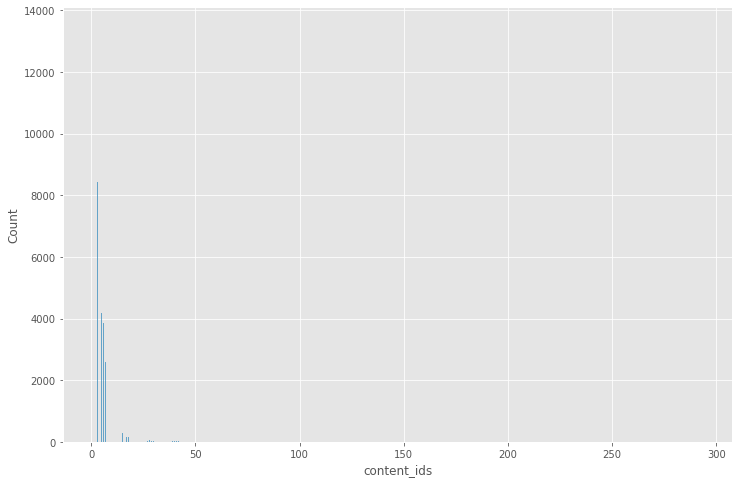

In [163]:
sns.histplot(data=num_target_df)

In [64]:
num_target_df.describe()

count    61517.000000
mean         4.550271
std          6.700255
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
max        293.000000
Name: content_ids, dtype: float64

In [166]:
num_target_df[num_target_df>100]

692      118
4923     150
5090     108
5506     106
5633     214
6951     150
7893     149
12052    192
14263    116
15944    123
18352    115
19481    142
21110    270
21347    131
24392    116
24966    168
31283    111
34978    266
39702    106
39971    110
40769    152
41506    170
41986    189
42790    125
42981    264
44543    205
46733    111
47249    293
53929    108
57562    128
58181    149
58471    105
58492    140
60072    147
Name: content_ids, dtype: int64

In [38]:
topics

,id,title,description,channel,category,level,language,parent,has_content
0,t_00004da3a1b2,Откриването на резисторите,"Изследване на материали, които предизвикват на...",000cf7,source,4,bg,t_16e29365b50d,True
1,t_000095e03056,Unit 3.3 Enlargements and Similarities,NaN,b3f329,aligned,2,en,t_aa32fb6252dc,False
2,t_00068291e9a4,Entradas e saídas de uma função,Entenda um pouco mais sobre funções.,8e286a,source,4,pt,t_d14b6c2a2b70,True
3,t_00069b63a70a,Transcripts,NaN,6e3ba4,source,3,en,t_4054df11a74e,True
4,t_0006d41a73a8,Графики на експоненциални функции (Алгебра 2 н...,Научи повече за графиките на сложните показате...,000cf7,source,4,bg,t_e2452e21d252,True
...,...,...,...,...,...,...,...,...,...
76967,t_fffb0bf2801d,4.3 Graph of functions,NaN,e77b55,aligned,4,en,t_676e6a1a4dc7,False
76968,t_fffbe1d5d43c,Inscribed shapes problem solving,Use properties of inscribed angles to prove pr...,0c929f,source,4,sw,t_50145b9bab3f,True
76969,t_fffe14f1be1e,Lección 7,NaN,6e90a7,aligned,6,es,t_d448c707984d,True
76970,t_fffe811a6da9,تحديد العلاقة بين الإحداثيّات القطبية والإحداث...,5b9e5ca86571f90499ea987f,9fd860,source,2,ar,t_5b4f3ba4eb7d,True


In [39]:
sub

,topic_id,content_ids
0,t_00004da3a1b2,c_1108dd0c7a5d c_376c5a8eb028 c_5bc0e1e2cba0 c...
1,t_00068291e9a4,c_639ea2ef9c95 c_89ce9367be10 c_ac1672cdcd2c c...
2,t_00069b63a70a,c_11a1dc0bfb99
3,t_0006d41a73a8,c_0c6473c3480d c_1c57a1316568 c_5e375cf14c47 c...
4,t_4054df11a74e,c_3695c5dc1df6 c_f2d184a98231


In [16]:
# =====================
# Main
# =====================

# setup
cfg = setup(Config)
LOGGER = get_logger(Config.OUTPUT_EXP)

LOGGER.info(f"tokenizers.__version__: {tokenizers.__version__}")
LOGGER.info(f"transformers.__version__: {transformers.__version__}")

# main
train = pd.read_csv(os.path.join(cfg.INPUT, 'train.csv'))
test = pd.read_csv(os.path.join(cfg.INPUT, 'test.csv'))
sub = pd.read_csv(os.path.join(cfg.INPUT, 'sample_submission.csv'))

train = processing_features(train)

cfg.tokenizer = AutoTokenizer.from_pretrained(cfg.MODEL_PATH)
cfg.tokenizer.save_pretrained(os.path.join(cfg.OUTPUT_EXP, 'tokenizer'))
cfg.folds = get_multilabelstratifiedkfold(train, cfg.target_list, cfg.num_fold, cfg.seed)
cfg.folds.to_csv(os.path.join(cfg.EXP_PREDS, 'folds.csv'))

score = training(cfg, train)

if cfg.upload_from_colab:
    from kaggle.api.kaggle_api_extended import KaggleApi
    dataset_create_new(dataset_name=Config.EXP, upload_dir=Config.OUTPUT_EXP)

tokenizers.__version__: 0.12.1
transformers.__version__: 4.20.1


env: TOKENIZERS_PARALLELISM=true


============================== Fold0 ==============================
==================== epoch0 ====================


  0%|          | 0/440 [00:00<?, ?it/s]

Fold: 0, Epoch: 0/5, Step: 40 | val_loss: 1.68937, score: 2.28751
Fold: 0, Epoch: 0/5, Step: 80 | val_loss: 0.23675, score: 0.70608
Fold: 0, Epoch: 0/5, Step: 120 | val_loss: 0.14364, score: 0.53861
Fold: 0, Epoch: 0/5, Step: 160 | val_loss: 0.14033, score: 0.5285
Fold: 0, Epoch: 0/5, Step: 200 | val_loss: 0.1283, score: 0.50636
Fold: 0, Epoch: 0/5, Step: 240 | val_loss: 0.11897, score: 0.48797
Fold: 0, Epoch: 0/5, Step: 280 | val_loss: 0.10919, score: 0.46783
Fold: 0, Epoch: 0/5, Step: 320 | val_loss: 0.14399, score: 0.52949
Fold: 0, Epoch: 0/5, Step: 360 | val_loss: 0.12367, score: 0.49766
Fold: 0, Epoch: 0/5, Step: 400 | val_loss: 0.11565, score: 0.48172
Fold0, Epoch0/5 | train_loss: 0.38747
Fold: 0, Epoch: 0/5, Step: end | val_loss: 0.10683, score: 0.46239
==================== epoch1 ====================


  0%|          | 0/440 [00:00<?, ?it/s]

Fold: 0, Epoch: 1/5, Step: 40 | val_loss: 0.11697, score: 0.48414
Fold: 0, Epoch: 1/5, Step: 80 | val_loss: 0.11148, score: 0.47267
Fold: 0, Epoch: 1/5, Step: 120 | val_loss: 0.14372, score: 0.53458
Fold: 0, Epoch: 1/5, Step: 160 | val_loss: 0.10587, score: 0.46092
Fold: 0, Epoch: 1/5, Step: 200 | val_loss: 0.11316, score: 0.4762
Fold: 0, Epoch: 1/5, Step: 240 | val_loss: 0.12201, score: 0.49411
Fold: 0, Epoch: 1/5, Step: 280 | val_loss: 0.11264, score: 0.47439
Fold: 0, Epoch: 1/5, Step: 320 | val_loss: 0.11989, score: 0.48968
Fold: 0, Epoch: 1/5, Step: 360 | val_loss: 0.11134, score: 0.47067
Fold: 0, Epoch: 1/5, Step: 400 | val_loss: 0.1052, score: 0.45897
Fold0, Epoch1/5 | train_loss: 0.11464
Fold: 0, Epoch: 1/5, Step: end | val_loss: 0.10518, score: 0.4591
==================== epoch2 ====================


  0%|          | 0/440 [00:00<?, ?it/s]

Fold: 0, Epoch: 2/5, Step: 40 | val_loss: 0.11399, score: 0.47868
Fold: 0, Epoch: 2/5, Step: 80 | val_loss: 0.10824, score: 0.46587
Fold: 0, Epoch: 2/5, Step: 120 | val_loss: 0.10192, score: 0.45199
Fold: 0, Epoch: 2/5, Step: 160 | val_loss: 0.10115, score: 0.4503
Fold: 0, Epoch: 2/5, Step: 200 | val_loss: 0.10948, score: 0.46855
Fold: 0, Epoch: 2/5, Step: 240 | val_loss: 0.10289, score: 0.4542
Fold: 0, Epoch: 2/5, Step: 280 | val_loss: 0.10809, score: 0.46559
Fold: 0, Epoch: 2/5, Step: 320 | val_loss: 0.10793, score: 0.46421
Fold: 0, Epoch: 2/5, Step: 360 | val_loss: 0.10063, score: 0.44901
Fold: 0, Epoch: 2/5, Step: 400 | val_loss: 0.10322, score: 0.45471
Fold0, Epoch2/5 | train_loss: 0.10371
Fold: 0, Epoch: 2/5, Step: end | val_loss: 0.10422, score: 0.45708
==================== epoch3 ====================


  0%|          | 0/440 [00:00<?, ?it/s]

Fold: 0, Epoch: 3/5, Step: 40 | val_loss: 0.10954, score: 0.46909
Fold: 0, Epoch: 3/5, Step: 80 | val_loss: 0.10426, score: 0.45717
Fold: 0, Epoch: 3/5, Step: 120 | val_loss: 0.10019, score: 0.44815
Fold: 0, Epoch: 3/5, Step: 160 | val_loss: 0.10207, score: 0.45252
Fold: 0, Epoch: 3/5, Step: 200 | val_loss: 0.10237, score: 0.4527
Fold: 0, Epoch: 3/5, Step: 240 | val_loss: 0.10218, score: 0.45264
Fold: 0, Epoch: 3/5, Step: 280 | val_loss: 0.10004, score: 0.4476
Fold: 0, Epoch: 3/5, Step: 320 | val_loss: 0.10236, score: 0.45241
Fold: 0, Epoch: 3/5, Step: 360 | val_loss: 0.10046, score: 0.44841
Fold: 0, Epoch: 3/5, Step: 400 | val_loss: 0.10085, score: 0.44961
Fold0, Epoch3/5 | train_loss: 0.09547
Fold: 0, Epoch: 3/5, Step: end | val_loss: 0.09942, score: 0.44624
==================== epoch4 ====================


  0%|          | 0/440 [00:00<?, ?it/s]

Fold: 0, Epoch: 4/5, Step: 40 | val_loss: 0.10041, score: 0.44853
Fold: 0, Epoch: 4/5, Step: 80 | val_loss: 0.09947, score: 0.44631
Fold: 0, Epoch: 4/5, Step: 120 | val_loss: 0.09865, score: 0.44458
Fold: 0, Epoch: 4/5, Step: 160 | val_loss: 0.10141, score: 0.4508
Fold: 0, Epoch: 4/5, Step: 200 | val_loss: 0.0991, score: 0.44551
Fold: 0, Epoch: 4/5, Step: 240 | val_loss: 0.09878, score: 0.44473
Fold: 0, Epoch: 4/5, Step: 280 | val_loss: 0.099, score: 0.44523
Fold: 0, Epoch: 4/5, Step: 320 | val_loss: 0.0993, score: 0.44594
Fold: 0, Epoch: 4/5, Step: 360 | val_loss: 0.09911, score: 0.44551
Fold: 0, Epoch: 4/5, Step: 400 | val_loss: 0.09918, score: 0.44568
Fold0, Epoch4/5 | train_loss: 0.08987
Fold: 0, Epoch: 4/5, Step: end | val_loss: 0.09917, score: 0.44565
============================== Fold1 ==============================
==================== epoch0 ====================


  0%|          | 0/440 [00:00<?, ?it/s]

Fold: 1, Epoch: 0/5, Step: 40 | val_loss: 1.94304, score: 2.53146
Fold: 1, Epoch: 0/5, Step: 80 | val_loss: 0.29822, score: 0.79623
Fold: 1, Epoch: 0/5, Step: 120 | val_loss: 0.16042, score: 0.5708
Fold: 1, Epoch: 0/5, Step: 160 | val_loss: 0.12701, score: 0.50523
Fold: 1, Epoch: 0/5, Step: 200 | val_loss: 0.12339, score: 0.49838
Fold: 1, Epoch: 0/5, Step: 240 | val_loss: 0.12107, score: 0.49208
Fold: 1, Epoch: 0/5, Step: 280 | val_loss: 0.14202, score: 0.5326
Fold: 1, Epoch: 0/5, Step: 320 | val_loss: 0.11296, score: 0.47603
Fold: 1, Epoch: 0/5, Step: 360 | val_loss: 0.11481, score: 0.47999
Fold: 1, Epoch: 0/5, Step: 400 | val_loss: 0.11322, score: 0.47694
Fold1, Epoch0/5 | train_loss: 0.43001
Fold: 1, Epoch: 0/5, Step: end | val_loss: 0.12072, score: 0.49295
==================== epoch1 ====================


  0%|          | 0/440 [00:00<?, ?it/s]

Fold: 1, Epoch: 1/5, Step: 40 | val_loss: 0.11436, score: 0.47923
Fold: 1, Epoch: 1/5, Step: 80 | val_loss: 0.12235, score: 0.49446
Fold: 1, Epoch: 1/5, Step: 120 | val_loss: 0.11081, score: 0.47211
Fold: 1, Epoch: 1/5, Step: 160 | val_loss: 0.11769, score: 0.48674
Fold: 1, Epoch: 1/5, Step: 200 | val_loss: 0.11989, score: 0.49059
Fold: 1, Epoch: 1/5, Step: 240 | val_loss: 0.11711, score: 0.48388
Fold: 1, Epoch: 1/5, Step: 280 | val_loss: 0.11185, score: 0.47409
Fold: 1, Epoch: 1/5, Step: 320 | val_loss: 0.11313, score: 0.476
Fold: 1, Epoch: 1/5, Step: 360 | val_loss: 0.11911, score: 0.48862
Fold: 1, Epoch: 1/5, Step: 400 | val_loss: 0.11823, score: 0.48678
Fold1, Epoch1/5 | train_loss: 0.111
Fold: 1, Epoch: 1/5, Step: end | val_loss: 0.11357, score: 0.47741
==================== epoch2 ====================


  0%|          | 0/440 [00:00<?, ?it/s]

Fold: 1, Epoch: 2/5, Step: 40 | val_loss: 0.11347, score: 0.47749
Fold: 1, Epoch: 2/5, Step: 80 | val_loss: 0.1098, score: 0.46972
Fold: 1, Epoch: 2/5, Step: 120 | val_loss: 0.14176, score: 0.5346
Fold: 1, Epoch: 2/5, Step: 160 | val_loss: 0.11417, score: 0.47832
Fold: 1, Epoch: 2/5, Step: 200 | val_loss: 0.10599, score: 0.46153
Fold: 1, Epoch: 2/5, Step: 240 | val_loss: 0.11977, score: 0.49131
Fold: 1, Epoch: 2/5, Step: 280 | val_loss: 0.11006, score: 0.47007
Fold: 1, Epoch: 2/5, Step: 320 | val_loss: 0.11335, score: 0.47733
Fold: 1, Epoch: 2/5, Step: 360 | val_loss: 0.10368, score: 0.45631
Fold: 1, Epoch: 2/5, Step: 400 | val_loss: 0.10968, score: 0.46952
Fold1, Epoch2/5 | train_loss: 0.10406
Fold: 1, Epoch: 2/5, Step: end | val_loss: 0.10473, score: 0.45842
==================== epoch3 ====================


  0%|          | 0/440 [00:00<?, ?it/s]

Fold: 1, Epoch: 3/5, Step: 40 | val_loss: 0.11661, score: 0.48439
Fold: 1, Epoch: 3/5, Step: 80 | val_loss: 0.11284, score: 0.47612
Fold: 1, Epoch: 3/5, Step: 120 | val_loss: 0.10629, score: 0.46199
Fold: 1, Epoch: 3/5, Step: 160 | val_loss: 0.10528, score: 0.45956
Fold: 1, Epoch: 3/5, Step: 200 | val_loss: 0.10471, score: 0.45847
Fold: 1, Epoch: 3/5, Step: 240 | val_loss: 0.10462, score: 0.45822
Fold: 1, Epoch: 3/5, Step: 280 | val_loss: 0.1035, score: 0.4558
Fold: 1, Epoch: 3/5, Step: 320 | val_loss: 0.10454, score: 0.45805
Fold: 1, Epoch: 3/5, Step: 360 | val_loss: 0.105, score: 0.45919
Fold: 1, Epoch: 3/5, Step: 400 | val_loss: 0.10415, score: 0.4574
Fold1, Epoch3/5 | train_loss: 0.09478
Fold: 1, Epoch: 3/5, Step: end | val_loss: 0.10449, score: 0.45814
==================== epoch4 ====================


  0%|          | 0/440 [00:00<?, ?it/s]

Fold: 1, Epoch: 4/5, Step: 40 | val_loss: 0.10391, score: 0.45676
Fold: 1, Epoch: 4/5, Step: 80 | val_loss: 0.10442, score: 0.45781
wandb: Network error (ConnectionError), entering retry loop.
Fold: 1, Epoch: 4/5, Step: 120 | val_loss: 0.1038, score: 0.45655
Fold: 1, Epoch: 4/5, Step: 160 | val_loss: 0.1048, score: 0.45887
Fold: 1, Epoch: 4/5, Step: 200 | val_loss: 0.104, score: 0.45702
Fold: 1, Epoch: 4/5, Step: 240 | val_loss: 0.10397, score: 0.45696
Fold: 1, Epoch: 4/5, Step: 280 | val_loss: 0.10407, score: 0.45724
Fold: 1, Epoch: 4/5, Step: 320 | val_loss: 0.10391, score: 0.45683
Fold: 1, Epoch: 4/5, Step: 360 | val_loss: 0.10387, score: 0.45674
Fold: 1, Epoch: 4/5, Step: 400 | val_loss: 0.10379, score: 0.45654
Fold1, Epoch4/5 | train_loss: 0.08973
Fold: 1, Epoch: 4/5, Step: end | val_loss: 0.10374, score: 0.45643
============================== Fold2 ==============================
==================== epoch0 ====================


  0%|          | 0/440 [00:00<?, ?it/s]

Fold: 2, Epoch: 0/5, Step: 40 | val_loss: 1.40984, score: 2.01739
Fold: 2, Epoch: 0/5, Step: 80 | val_loss: 0.21718, score: 0.6708
Fold: 2, Epoch: 0/5, Step: 120 | val_loss: 0.15265, score: 0.55787
Fold: 2, Epoch: 0/5, Step: 160 | val_loss: 0.13468, score: 0.52102
Fold: 2, Epoch: 0/5, Step: 200 | val_loss: 0.11493, score: 0.48134
Fold: 2, Epoch: 0/5, Step: 240 | val_loss: 0.13771, score: 0.52592
Fold: 2, Epoch: 0/5, Step: 280 | val_loss: 0.11585, score: 0.48292
Fold: 2, Epoch: 0/5, Step: 320 | val_loss: 0.11216, score: 0.47513
Fold: 2, Epoch: 0/5, Step: 360 | val_loss: 0.11688, score: 0.48454
Fold: 2, Epoch: 0/5, Step: 400 | val_loss: 0.14281, score: 0.53299
Fold2, Epoch0/5 | train_loss: 0.34099
Fold: 2, Epoch: 0/5, Step: end | val_loss: 0.12048, score: 0.49188
==================== epoch1 ====================


  0%|          | 0/440 [00:00<?, ?it/s]

Fold: 2, Epoch: 1/5, Step: 40 | val_loss: 0.11069, score: 0.47132
Fold: 2, Epoch: 1/5, Step: 80 | val_loss: 0.10912, score: 0.46881
Fold: 2, Epoch: 1/5, Step: 120 | val_loss: 0.11256, score: 0.47566
Fold: 2, Epoch: 1/5, Step: 160 | val_loss: 0.1263, score: 0.50351
Fold: 2, Epoch: 1/5, Step: 200 | val_loss: 0.11863, score: 0.48758
Fold: 2, Epoch: 1/5, Step: 240 | val_loss: 0.11741, score: 0.48581
Fold: 2, Epoch: 1/5, Step: 280 | val_loss: 0.11267, score: 0.47592
Fold: 2, Epoch: 1/5, Step: 320 | val_loss: 0.10506, score: 0.45938
Fold: 2, Epoch: 1/5, Step: 360 | val_loss: 0.10929, score: 0.46821
Fold: 2, Epoch: 1/5, Step: 400 | val_loss: 0.10908, score: 0.46809
Fold2, Epoch1/5 | train_loss: 0.11367
Fold: 2, Epoch: 1/5, Step: end | val_loss: 0.11483, score: 0.48
==================== epoch2 ====================


  0%|          | 0/440 [00:00<?, ?it/s]

Fold: 2, Epoch: 2/5, Step: 40 | val_loss: 0.10426, score: 0.45762
Fold: 2, Epoch: 2/5, Step: 80 | val_loss: 0.11401, score: 0.47849
Fold: 2, Epoch: 2/5, Step: 120 | val_loss: 0.10363, score: 0.45608
Fold: 2, Epoch: 2/5, Step: 160 | val_loss: 0.11741, score: 0.48548
Fold: 2, Epoch: 2/5, Step: 200 | val_loss: 0.12608, score: 0.50293
Fold: 2, Epoch: 2/5, Step: 240 | val_loss: 0.12916, score: 0.50822
Fold: 2, Epoch: 2/5, Step: 280 | val_loss: 0.10412, score: 0.45715
Fold: 2, Epoch: 2/5, Step: 320 | val_loss: 0.11047, score: 0.47101
Fold: 2, Epoch: 2/5, Step: 360 | val_loss: 0.10721, score: 0.46371
Fold: 2, Epoch: 2/5, Step: 400 | val_loss: 0.11765, score: 0.48595
Fold2, Epoch2/5 | train_loss: 0.10271
Fold: 2, Epoch: 2/5, Step: end | val_loss: 0.10886, score: 0.468
==================== epoch3 ====================


  0%|          | 0/440 [00:00<?, ?it/s]

Fold: 2, Epoch: 3/5, Step: 40 | val_loss: 0.10733, score: 0.46458
Fold: 2, Epoch: 3/5, Step: 80 | val_loss: 0.10348, score: 0.45604
Fold: 2, Epoch: 3/5, Step: 120 | val_loss: 0.10824, score: 0.46611
Fold: 2, Epoch: 3/5, Step: 160 | val_loss: 0.10275, score: 0.45428
Fold: 2, Epoch: 3/5, Step: 200 | val_loss: 0.1031, score: 0.45482
Fold: 2, Epoch: 3/5, Step: 240 | val_loss: 0.10244, score: 0.45348
Fold: 2, Epoch: 3/5, Step: 280 | val_loss: 0.1089, score: 0.4675
Fold: 2, Epoch: 3/5, Step: 320 | val_loss: 0.10229, score: 0.45308
Fold: 2, Epoch: 3/5, Step: 360 | val_loss: 0.10542, score: 0.45981
Fold: 2, Epoch: 3/5, Step: 400 | val_loss: 0.10391, score: 0.45677
Fold2, Epoch3/5 | train_loss: 0.0941
Fold: 2, Epoch: 3/5, Step: end | val_loss: 0.10438, score: 0.45749
==================== epoch4 ====================


  0%|          | 0/440 [00:00<?, ?it/s]

Fold: 2, Epoch: 4/5, Step: 40 | val_loss: 0.1023, score: 0.45324
Fold: 2, Epoch: 4/5, Step: 80 | val_loss: 0.10263, score: 0.45397
Fold: 2, Epoch: 4/5, Step: 120 | val_loss: 0.1022, score: 0.45299
Fold: 2, Epoch: 4/5, Step: 160 | val_loss: 0.10335, score: 0.45533
Fold: 2, Epoch: 4/5, Step: 200 | val_loss: 0.10277, score: 0.45408
Fold: 2, Epoch: 4/5, Step: 240 | val_loss: 0.10343, score: 0.45556
Fold: 2, Epoch: 4/5, Step: 280 | val_loss: 0.10323, score: 0.45509
Fold: 2, Epoch: 4/5, Step: 320 | val_loss: 0.10287, score: 0.45433
Fold: 2, Epoch: 4/5, Step: 360 | val_loss: 0.1025, score: 0.45349
Fold: 2, Epoch: 4/5, Step: 400 | val_loss: 0.10243, score: 0.45334
Fold2, Epoch4/5 | train_loss: 0.08939
Fold: 2, Epoch: 4/5, Step: end | val_loss: 0.10243, score: 0.45334
============================== Fold3 ==============================
==================== epoch0 ====================


  0%|          | 0/440 [00:00<?, ?it/s]

Fold: 3, Epoch: 0/5, Step: 40 | val_loss: 1.83664, score: 2.42428
Fold: 3, Epoch: 0/5, Step: 80 | val_loss: 0.25528, score: 0.73303
Fold: 3, Epoch: 0/5, Step: 120 | val_loss: 0.15586, score: 0.56219
Fold: 3, Epoch: 0/5, Step: 160 | val_loss: 0.11996, score: 0.49085
Fold: 3, Epoch: 0/5, Step: 200 | val_loss: 0.11018, score: 0.47018
Fold: 3, Epoch: 0/5, Step: 240 | val_loss: 0.12297, score: 0.49408
Fold: 3, Epoch: 0/5, Step: 280 | val_loss: 0.11767, score: 0.48661
Fold: 3, Epoch: 0/5, Step: 320 | val_loss: 0.1151, score: 0.48032
Fold: 3, Epoch: 0/5, Step: 360 | val_loss: 0.10655, score: 0.46156
Fold: 3, Epoch: 0/5, Step: 400 | val_loss: 0.11092, score: 0.46983
Fold3, Epoch0/5 | train_loss: 0.40702
Fold: 3, Epoch: 0/5, Step: end | val_loss: 0.10655, score: 0.46136
==================== epoch1 ====================


  0%|          | 0/440 [00:00<?, ?it/s]

Fold: 3, Epoch: 1/5, Step: 40 | val_loss: 0.11949, score: 0.48894
Fold: 3, Epoch: 1/5, Step: 80 | val_loss: 0.12706, score: 0.50276
Fold: 3, Epoch: 1/5, Step: 120 | val_loss: 0.10404, score: 0.45693
Fold: 3, Epoch: 1/5, Step: 160 | val_loss: 0.10652, score: 0.46257
Fold: 3, Epoch: 1/5, Step: 200 | val_loss: 0.10364, score: 0.45532
Fold: 3, Epoch: 1/5, Step: 240 | val_loss: 0.11093, score: 0.4709
Fold: 3, Epoch: 1/5, Step: 280 | val_loss: 0.10433, score: 0.45729
Fold: 3, Epoch: 1/5, Step: 320 | val_loss: 0.10789, score: 0.46453
Fold: 3, Epoch: 1/5, Step: 360 | val_loss: 0.11942, score: 0.48695
Fold: 3, Epoch: 1/5, Step: 400 | val_loss: 0.10602, score: 0.46102
Fold3, Epoch1/5 | train_loss: 0.10994
Fold: 3, Epoch: 1/5, Step: end | val_loss: 0.1052, score: 0.45891
==================== epoch2 ====================


  0%|          | 0/440 [00:00<?, ?it/s]

Fold: 3, Epoch: 2/5, Step: 40 | val_loss: 0.10203, score: 0.45159
Fold: 3, Epoch: 2/5, Step: 80 | val_loss: 0.11041, score: 0.47013
Fold: 3, Epoch: 2/5, Step: 120 | val_loss: 0.11712, score: 0.48265
Fold: 3, Epoch: 2/5, Step: 160 | val_loss: 0.10107, score: 0.44993
Fold: 3, Epoch: 2/5, Step: 200 | val_loss: 0.10209, score: 0.45208
Fold: 3, Epoch: 2/5, Step: 240 | val_loss: 0.10326, score: 0.4545
Fold: 3, Epoch: 2/5, Step: 280 | val_loss: 0.10442, score: 0.45747
Fold: 3, Epoch: 2/5, Step: 320 | val_loss: 0.13681, score: 0.52459
Fold: 3, Epoch: 2/5, Step: 360 | val_loss: 0.10764, score: 0.4648
Fold: 3, Epoch: 2/5, Step: 400 | val_loss: 0.11229, score: 0.47341
Fold3, Epoch2/5 | train_loss: 0.10281
Fold: 3, Epoch: 2/5, Step: end | val_loss: 0.102, score: 0.45207
==================== epoch3 ====================


  0%|          | 0/440 [00:00<?, ?it/s]

Fold: 3, Epoch: 3/5, Step: 40 | val_loss: 0.10137, score: 0.4506
Fold: 3, Epoch: 3/5, Step: 80 | val_loss: 0.10454, score: 0.45774
Fold: 3, Epoch: 3/5, Step: 120 | val_loss: 0.10141, score: 0.45067
Fold: 3, Epoch: 3/5, Step: 160 | val_loss: 0.10126, score: 0.45001
Fold: 3, Epoch: 3/5, Step: 200 | val_loss: 0.09845, score: 0.44408
Fold: 3, Epoch: 3/5, Step: 240 | val_loss: 0.10085, score: 0.44933
Fold: 3, Epoch: 3/5, Step: 280 | val_loss: 0.10353, score: 0.45567
Fold: 3, Epoch: 3/5, Step: 320 | val_loss: 0.09993, score: 0.44744
Fold: 3, Epoch: 3/5, Step: 360 | val_loss: 0.09949, score: 0.44664
Fold: 3, Epoch: 3/5, Step: 400 | val_loss: 0.09954, score: 0.44658
Fold3, Epoch3/5 | train_loss: 0.09492
Fold: 3, Epoch: 3/5, Step: end | val_loss: 0.09969, score: 0.4466
==================== epoch4 ====================


  0%|          | 0/440 [00:00<?, ?it/s]

Fold: 3, Epoch: 4/5, Step: 40 | val_loss: 0.09936, score: 0.44617
Fold: 3, Epoch: 4/5, Step: 80 | val_loss: 0.09965, score: 0.44691
Fold: 3, Epoch: 4/5, Step: 120 | val_loss: 0.09863, score: 0.44424
Fold: 3, Epoch: 4/5, Step: 160 | val_loss: 0.09825, score: 0.44355
Fold: 3, Epoch: 4/5, Step: 200 | val_loss: 0.09909, score: 0.44529
Fold: 3, Epoch: 4/5, Step: 240 | val_loss: 0.09815, score: 0.44342
Fold: 3, Epoch: 4/5, Step: 280 | val_loss: 0.09835, score: 0.4437
Fold: 3, Epoch: 4/5, Step: 320 | val_loss: 0.09835, score: 0.44366
Fold: 3, Epoch: 4/5, Step: 360 | val_loss: 0.09826, score: 0.44347
Fold: 3, Epoch: 4/5, Step: 400 | val_loss: 0.09824, score: 0.44343
Fold3, Epoch4/5 | train_loss: 0.08934
Fold: 3, Epoch: 4/5, Step: end | val_loss: 0.09824, score: 0.44343
============================== Fold4 ==============================
==================== epoch0 ====================


  0%|          | 0/440 [00:00<?, ?it/s]

Fold: 4, Epoch: 0/5, Step: 40 | val_loss: 1.84024, score: 2.44121
Fold: 4, Epoch: 0/5, Step: 80 | val_loss: 0.29609, score: 0.80007
Fold: 4, Epoch: 0/5, Step: 120 | val_loss: 0.17377, score: 0.59511
Fold: 4, Epoch: 0/5, Step: 160 | val_loss: 0.13124, score: 0.51548
Fold: 4, Epoch: 0/5, Step: 200 | val_loss: 0.12435, score: 0.50131
Fold: 4, Epoch: 0/5, Step: 240 | val_loss: 0.12405, score: 0.50121
Fold: 4, Epoch: 0/5, Step: 280 | val_loss: 0.11858, score: 0.48852
Fold: 4, Epoch: 0/5, Step: 320 | val_loss: 0.12588, score: 0.50425
Fold: 4, Epoch: 0/5, Step: 360 | val_loss: 0.13739, score: 0.52727
Fold: 4, Epoch: 0/5, Step: 400 | val_loss: 0.12364, score: 0.49919
Fold4, Epoch0/5 | train_loss: 0.42785
Fold: 4, Epoch: 0/5, Step: end | val_loss: 0.12717, score: 0.50581
==================== epoch1 ====================


  0%|          | 0/440 [00:00<?, ?it/s]

Fold: 4, Epoch: 1/5, Step: 40 | val_loss: 0.11139, score: 0.47354
Fold: 4, Epoch: 1/5, Step: 80 | val_loss: 0.12874, score: 0.50575
Fold: 4, Epoch: 1/5, Step: 120 | val_loss: 0.11951, score: 0.49222
Fold: 4, Epoch: 1/5, Step: 160 | val_loss: 0.11738, score: 0.4862
Fold: 4, Epoch: 1/5, Step: 200 | val_loss: 0.11787, score: 0.48736
Fold: 4, Epoch: 1/5, Step: 240 | val_loss: 0.12277, score: 0.49681
Fold: 4, Epoch: 1/5, Step: 280 | val_loss: 0.13128, score: 0.51315
Fold: 4, Epoch: 1/5, Step: 320 | val_loss: 0.10804, score: 0.46632
Fold: 4, Epoch: 1/5, Step: 360 | val_loss: 0.12516, score: 0.50036
Fold: 4, Epoch: 1/5, Step: 400 | val_loss: 0.12825, score: 0.50956
Fold4, Epoch1/5 | train_loss: 0.11098
Fold: 4, Epoch: 1/5, Step: end | val_loss: 0.10919, score: 0.4695
==================== epoch2 ====================


  0%|          | 0/440 [00:00<?, ?it/s]

Fold: 4, Epoch: 2/5, Step: 40 | val_loss: 0.12346, score: 0.49945
Fold: 4, Epoch: 2/5, Step: 80 | val_loss: 0.11296, score: 0.47739
Fold: 4, Epoch: 2/5, Step: 120 | val_loss: 0.11007, score: 0.47102
Fold: 4, Epoch: 2/5, Step: 160 | val_loss: 0.10714, score: 0.46453
Fold: 4, Epoch: 2/5, Step: 200 | val_loss: 0.11435, score: 0.48
Fold: 4, Epoch: 2/5, Step: 240 | val_loss: 0.11136, score: 0.47352
Fold: 4, Epoch: 2/5, Step: 280 | val_loss: 0.10838, score: 0.46677
Fold: 4, Epoch: 2/5, Step: 320 | val_loss: 0.11238, score: 0.47627
Fold: 4, Epoch: 2/5, Step: 360 | val_loss: 0.1044, score: 0.4583
Fold: 4, Epoch: 2/5, Step: 400 | val_loss: 0.10555, score: 0.4607
Fold4, Epoch2/5 | train_loss: 0.10135
Fold: 4, Epoch: 2/5, Step: end | val_loss: 0.10559, score: 0.4613
==================== epoch3 ====================


  0%|          | 0/440 [00:00<?, ?it/s]

Fold: 4, Epoch: 3/5, Step: 40 | val_loss: 0.11302, score: 0.47688
Fold: 4, Epoch: 3/5, Step: 80 | val_loss: 0.10395, score: 0.45716
Fold: 4, Epoch: 3/5, Step: 120 | val_loss: 0.11174, score: 0.47472
Fold: 4, Epoch: 3/5, Step: 160 | val_loss: 0.10888, score: 0.46816
Fold: 4, Epoch: 3/5, Step: 200 | val_loss: 0.10845, score: 0.46702
Fold: 4, Epoch: 3/5, Step: 240 | val_loss: 0.10737, score: 0.46496
Fold: 4, Epoch: 3/5, Step: 280 | val_loss: 0.10274, score: 0.45466
Fold: 4, Epoch: 3/5, Step: 320 | val_loss: 0.10334, score: 0.45611
Fold: 4, Epoch: 3/5, Step: 360 | val_loss: 0.10364, score: 0.45658
Fold: 4, Epoch: 3/5, Step: 400 | val_loss: 0.10428, score: 0.45804
Fold4, Epoch3/5 | train_loss: 0.09517
Fold: 4, Epoch: 3/5, Step: end | val_loss: 0.10412, score: 0.45754
==================== epoch4 ====================


  0%|          | 0/440 [00:00<?, ?it/s]

Fold: 4, Epoch: 4/5, Step: 40 | val_loss: 0.10849, score: 0.46779
Fold: 4, Epoch: 4/5, Step: 80 | val_loss: 0.10307, score: 0.45554
Fold: 4, Epoch: 4/5, Step: 120 | val_loss: 0.10328, score: 0.45598
Fold: 4, Epoch: 4/5, Step: 160 | val_loss: 0.10542, score: 0.46076
Fold: 4, Epoch: 4/5, Step: 200 | val_loss: 0.10318, score: 0.45569
Fold: 4, Epoch: 4/5, Step: 240 | val_loss: 0.10309, score: 0.45551
Fold: 4, Epoch: 4/5, Step: 280 | val_loss: 0.10316, score: 0.45569
Fold: 4, Epoch: 4/5, Step: 320 | val_loss: 0.10363, score: 0.45679
Fold: 4, Epoch: 4/5, Step: 360 | val_loss: 0.10303, score: 0.45538
Fold: 4, Epoch: 4/5, Step: 400 | val_loss: 0.10298, score: 0.45524
Fold4, Epoch4/5 | train_loss: 0.09013
Fold: 4, Epoch: 4/5, Step: end | val_loss: 0.10294, score: 0.45517
============================== Fold5 ==============================
==================== epoch0 ====================


  0%|          | 0/440 [00:00<?, ?it/s]

Fold: 5, Epoch: 0/5, Step: 40 | val_loss: 1.81597, score: 2.41364
Fold: 5, Epoch: 0/5, Step: 80 | val_loss: 0.24957, score: 0.71965
Fold: 5, Epoch: 0/5, Step: 120 | val_loss: 0.16304, score: 0.57496
Fold: 5, Epoch: 0/5, Step: 160 | val_loss: 0.11783, score: 0.48677
Fold: 5, Epoch: 0/5, Step: 200 | val_loss: 0.12283, score: 0.49629
Fold: 5, Epoch: 0/5, Step: 240 | val_loss: 0.11663, score: 0.4832
Fold: 5, Epoch: 0/5, Step: 280 | val_loss: 0.11327, score: 0.47714
Fold: 5, Epoch: 0/5, Step: 320 | val_loss: 0.12637, score: 0.49883
Fold: 5, Epoch: 0/5, Step: 360 | val_loss: 0.11137, score: 0.47229
Fold: 5, Epoch: 0/5, Step: 400 | val_loss: 0.12382, score: 0.49642
Fold5, Epoch0/5 | train_loss: 0.42069
Fold: 5, Epoch: 0/5, Step: end | val_loss: 0.10769, score: 0.46369
==================== epoch1 ====================


  0%|          | 0/440 [00:00<?, ?it/s]

Fold: 5, Epoch: 1/5, Step: 40 | val_loss: 0.10927, score: 0.46789
Fold: 5, Epoch: 1/5, Step: 80 | val_loss: 0.11424, score: 0.47765
Fold: 5, Epoch: 1/5, Step: 120 | val_loss: 0.10283, score: 0.45411
Fold: 5, Epoch: 1/5, Step: 160 | val_loss: 0.10404, score: 0.45596
Fold: 5, Epoch: 1/5, Step: 200 | val_loss: 0.11078, score: 0.47181
Fold: 5, Epoch: 1/5, Step: 240 | val_loss: 0.10318, score: 0.45447
Fold: 5, Epoch: 1/5, Step: 280 | val_loss: 0.10146, score: 0.45042
Fold: 5, Epoch: 1/5, Step: 320 | val_loss: 0.10447, score: 0.45745
Fold: 5, Epoch: 1/5, Step: 360 | val_loss: 0.11033, score: 0.46944
Fold: 5, Epoch: 1/5, Step: 400 | val_loss: 0.0996, score: 0.44634
Fold5, Epoch1/5 | train_loss: 0.11122
Fold: 5, Epoch: 1/5, Step: end | val_loss: 0.09898, score: 0.4453
==================== epoch2 ====================


  0%|          | 0/440 [00:00<?, ?it/s]

Fold: 5, Epoch: 2/5, Step: 40 | val_loss: 0.1061, score: 0.45905
Fold: 5, Epoch: 2/5, Step: 80 | val_loss: 0.09812, score: 0.443
Fold: 5, Epoch: 2/5, Step: 120 | val_loss: 0.10146, score: 0.45123
Fold: 5, Epoch: 2/5, Step: 160 | val_loss: 0.10264, score: 0.4527
Fold: 5, Epoch: 2/5, Step: 200 | val_loss: 0.10151, score: 0.45094
Fold: 5, Epoch: 2/5, Step: 240 | val_loss: 0.10132, score: 0.44958
Fold: 5, Epoch: 2/5, Step: 280 | val_loss: 0.10275, score: 0.45326
Fold: 5, Epoch: 2/5, Step: 320 | val_loss: 0.11356, score: 0.47657
Fold: 5, Epoch: 2/5, Step: 360 | val_loss: 0.10261, score: 0.45236
Fold: 5, Epoch: 2/5, Step: 400 | val_loss: 0.10523, score: 0.45839
Fold5, Epoch2/5 | train_loss: 0.10435
Fold: 5, Epoch: 2/5, Step: end | val_loss: 0.10214, score: 0.45161
==================== epoch3 ====================


  0%|          | 0/440 [00:00<?, ?it/s]

Fold: 5, Epoch: 3/5, Step: 40 | val_loss: 0.09613, score: 0.43886
Fold: 5, Epoch: 3/5, Step: 80 | val_loss: 0.10046, score: 0.44812
Fold: 5, Epoch: 3/5, Step: 120 | val_loss: 0.09514, score: 0.43613
Fold: 5, Epoch: 3/5, Step: 160 | val_loss: 0.0954, score: 0.43676
Fold: 5, Epoch: 3/5, Step: 200 | val_loss: 0.09472, score: 0.43538
Fold: 5, Epoch: 3/5, Step: 240 | val_loss: 0.10764, score: 0.46432
Fold: 5, Epoch: 3/5, Step: 280 | val_loss: 0.09748, score: 0.44165
Fold: 5, Epoch: 3/5, Step: 320 | val_loss: 0.09637, score: 0.43913
Fold: 5, Epoch: 3/5, Step: 360 | val_loss: 0.10141, score: 0.45055
Fold: 5, Epoch: 3/5, Step: 400 | val_loss: 0.09867, score: 0.44456
Fold5, Epoch3/5 | train_loss: 0.09536
Fold: 5, Epoch: 3/5, Step: end | val_loss: 0.09743, score: 0.44163
==================== epoch4 ====================


  0%|          | 0/440 [00:00<?, ?it/s]

Fold: 5, Epoch: 4/5, Step: 40 | val_loss: 0.09422, score: 0.4341
Fold: 5, Epoch: 4/5, Step: 80 | val_loss: 0.09619, score: 0.43868
Fold: 5, Epoch: 4/5, Step: 120 | val_loss: 0.09517, score: 0.43651
Fold: 5, Epoch: 4/5, Step: 160 | val_loss: 0.09486, score: 0.43559
Fold: 5, Epoch: 4/5, Step: 200 | val_loss: 0.09417, score: 0.43401
Fold: 5, Epoch: 4/5, Step: 240 | val_loss: 0.09412, score: 0.43387
Fold: 5, Epoch: 4/5, Step: 280 | val_loss: 0.09442, score: 0.43457
Fold: 5, Epoch: 4/5, Step: 320 | val_loss: 0.09463, score: 0.43509
Fold: 5, Epoch: 4/5, Step: 360 | val_loss: 0.0949, score: 0.43573
Fold: 5, Epoch: 4/5, Step: 400 | val_loss: 0.09478, score: 0.43545
Fold5, Epoch4/5 | train_loss: 0.09003
Fold: 5, Epoch: 4/5, Step: end | val_loss: 0.09478, score: 0.43545
============================== Fold6 ==============================
==================== epoch0 ====================


  0%|          | 0/440 [00:00<?, ?it/s]

Fold: 6, Epoch: 0/5, Step: 40 | val_loss: 1.82497, score: 2.42011
Fold: 6, Epoch: 0/5, Step: 80 | val_loss: 0.22062, score: 0.67958
Fold: 6, Epoch: 0/5, Step: 120 | val_loss: 0.14714, score: 0.54626
Fold: 6, Epoch: 0/5, Step: 160 | val_loss: 0.13308, score: 0.51823
Fold: 6, Epoch: 0/5, Step: 200 | val_loss: 0.12193, score: 0.49556
Fold: 6, Epoch: 0/5, Step: 240 | val_loss: 0.12394, score: 0.49881
Fold: 6, Epoch: 0/5, Step: 280 | val_loss: 0.11561, score: 0.48228
Fold: 6, Epoch: 0/5, Step: 320 | val_loss: 0.12002, score: 0.4908
Fold: 6, Epoch: 0/5, Step: 360 | val_loss: 0.11311, score: 0.47684
Fold: 6, Epoch: 0/5, Step: 400 | val_loss: 0.12763, score: 0.50653
Fold6, Epoch0/5 | train_loss: 0.41218
Fold: 6, Epoch: 0/5, Step: end | val_loss: 0.11176, score: 0.47381
==================== epoch1 ====================


  0%|          | 0/440 [00:00<?, ?it/s]

Fold: 6, Epoch: 1/5, Step: 40 | val_loss: 0.12974, score: 0.51037
Fold: 6, Epoch: 1/5, Step: 80 | val_loss: 0.11684, score: 0.48414
Fold: 6, Epoch: 1/5, Step: 120 | val_loss: 0.1135, score: 0.47772
Fold: 6, Epoch: 1/5, Step: 160 | val_loss: 0.12306, score: 0.49508
Fold: 6, Epoch: 1/5, Step: 200 | val_loss: 0.11289, score: 0.47623
Fold: 6, Epoch: 1/5, Step: 240 | val_loss: 0.11418, score: 0.4784
Fold: 6, Epoch: 1/5, Step: 280 | val_loss: 0.14292, score: 0.53696
Fold: 6, Epoch: 1/5, Step: 320 | val_loss: 0.11112, score: 0.47227
Fold: 6, Epoch: 1/5, Step: 360 | val_loss: 0.11415, score: 0.47843
Fold: 6, Epoch: 1/5, Step: 400 | val_loss: 0.11, score: 0.47044
Fold6, Epoch1/5 | train_loss: 0.11161
Fold: 6, Epoch: 1/5, Step: end | val_loss: 0.11246, score: 0.4757
==================== epoch2 ====================


  0%|          | 0/440 [00:00<?, ?it/s]

Fold: 6, Epoch: 2/5, Step: 40 | val_loss: 0.10727, score: 0.46416
Fold: 6, Epoch: 2/5, Step: 80 | val_loss: 0.11476, score: 0.48033
Fold: 6, Epoch: 2/5, Step: 120 | val_loss: 0.1173, score: 0.48503
Fold: 6, Epoch: 2/5, Step: 160 | val_loss: 0.11196, score: 0.47443
Fold: 6, Epoch: 2/5, Step: 200 | val_loss: 0.11139, score: 0.47319
Fold: 6, Epoch: 2/5, Step: 240 | val_loss: 0.11693, score: 0.48467
Fold: 6, Epoch: 2/5, Step: 280 | val_loss: 0.10854, score: 0.4669
Fold: 6, Epoch: 2/5, Step: 320 | val_loss: 0.10863, score: 0.467
Fold: 6, Epoch: 2/5, Step: 360 | val_loss: 0.11032, score: 0.47089
Fold: 6, Epoch: 2/5, Step: 400 | val_loss: 0.11134, score: 0.47261
Fold6, Epoch2/5 | train_loss: 0.10296
Fold: 6, Epoch: 2/5, Step: end | val_loss: 0.11787, score: 0.4868
==================== epoch3 ====================


  0%|          | 0/440 [00:00<?, ?it/s]

Fold: 6, Epoch: 3/5, Step: 40 | val_loss: 0.11204, score: 0.47424
Fold: 6, Epoch: 3/5, Step: 80 | val_loss: 0.11028, score: 0.47067
Fold: 6, Epoch: 3/5, Step: 120 | val_loss: 0.11203, score: 0.47438
Fold: 6, Epoch: 3/5, Step: 160 | val_loss: 0.11145, score: 0.47289
Fold: 6, Epoch: 3/5, Step: 200 | val_loss: 0.11828, score: 0.48812
Fold: 6, Epoch: 3/5, Step: 240 | val_loss: 0.10708, score: 0.46369
Fold: 6, Epoch: 3/5, Step: 280 | val_loss: 0.10775, score: 0.46517
Fold: 6, Epoch: 3/5, Step: 320 | val_loss: 0.1104, score: 0.471
Fold: 6, Epoch: 3/5, Step: 360 | val_loss: 0.10756, score: 0.46491
Fold: 6, Epoch: 3/5, Step: 400 | val_loss: 0.10904, score: 0.46818
Fold6, Epoch3/5 | train_loss: 0.09428
Fold: 6, Epoch: 3/5, Step: end | val_loss: 0.10805, score: 0.46576
==================== epoch4 ====================


  0%|          | 0/440 [00:00<?, ?it/s]

Fold: 6, Epoch: 4/5, Step: 40 | val_loss: 0.1084, score: 0.46664
Fold: 6, Epoch: 4/5, Step: 80 | val_loss: 0.1081, score: 0.466
Fold: 6, Epoch: 4/5, Step: 120 | val_loss: 0.1085, score: 0.46697
Fold: 6, Epoch: 4/5, Step: 160 | val_loss: 0.10753, score: 0.46469
Fold: 6, Epoch: 4/5, Step: 200 | val_loss: 0.10724, score: 0.46415
Fold: 6, Epoch: 4/5, Step: 240 | val_loss: 0.1071, score: 0.46374
Fold: 6, Epoch: 4/5, Step: 280 | val_loss: 0.10718, score: 0.46394
Fold: 6, Epoch: 4/5, Step: 320 | val_loss: 0.10702, score: 0.46362
Fold: 6, Epoch: 4/5, Step: 360 | val_loss: 0.10704, score: 0.46367
Fold: 6, Epoch: 4/5, Step: 400 | val_loss: 0.10705, score: 0.46368
Fold6, Epoch4/5 | train_loss: 0.08904
Fold: 6, Epoch: 4/5, Step: end | val_loss: 0.10703, score: 0.46364
============================== Fold7 ==============================
==================== epoch0 ====================


  0%|          | 0/440 [00:00<?, ?it/s]

Fold: 7, Epoch: 0/5, Step: 40 | val_loss: 1.83071, score: 2.41988
Fold: 7, Epoch: 0/5, Step: 80 | val_loss: 0.28277, score: 0.766
Fold: 7, Epoch: 0/5, Step: 120 | val_loss: 0.15521, score: 0.56086
Fold: 7, Epoch: 0/5, Step: 160 | val_loss: 0.13262, score: 0.51667
Fold: 7, Epoch: 0/5, Step: 200 | val_loss: 0.11837, score: 0.48727
Fold: 7, Epoch: 0/5, Step: 240 | val_loss: 0.11329, score: 0.47756
Fold: 7, Epoch: 0/5, Step: 280 | val_loss: 0.10969, score: 0.46914
Fold: 7, Epoch: 0/5, Step: 320 | val_loss: 0.11224, score: 0.47493
Fold: 7, Epoch: 0/5, Step: 360 | val_loss: 0.10736, score: 0.46314
Fold: 7, Epoch: 0/5, Step: 400 | val_loss: 0.099, score: 0.44538
Fold7, Epoch0/5 | train_loss: 0.43053
Fold: 7, Epoch: 0/5, Step: end | val_loss: 0.10266, score: 0.45416
==================== epoch1 ====================


  0%|          | 0/440 [00:00<?, ?it/s]

Fold: 7, Epoch: 1/5, Step: 40 | val_loss: 0.11284, score: 0.47514
Fold: 7, Epoch: 1/5, Step: 80 | val_loss: 0.09887, score: 0.44503
Fold: 7, Epoch: 1/5, Step: 120 | val_loss: 0.11497, score: 0.48024
Fold: 7, Epoch: 1/5, Step: 160 | val_loss: 0.10039, score: 0.44815
Fold: 7, Epoch: 1/5, Step: 200 | val_loss: 0.11703, score: 0.48432
Fold: 7, Epoch: 1/5, Step: 240 | val_loss: 0.11287, score: 0.47484
Fold: 7, Epoch: 1/5, Step: 280 | val_loss: 0.10248, score: 0.45313
Fold: 7, Epoch: 1/5, Step: 320 | val_loss: 0.09899, score: 0.4455
Fold: 7, Epoch: 1/5, Step: 360 | val_loss: 0.1071, score: 0.46294
Fold: 7, Epoch: 1/5, Step: 400 | val_loss: 0.10586, score: 0.45949
Fold7, Epoch1/5 | train_loss: 0.11121
Fold: 7, Epoch: 1/5, Step: end | val_loss: 0.10562, score: 0.4596
==================== epoch2 ====================


  0%|          | 0/440 [00:00<?, ?it/s]

Fold: 7, Epoch: 2/5, Step: 40 | val_loss: 0.10039, score: 0.44849
Fold: 7, Epoch: 2/5, Step: 80 | val_loss: 0.11925, score: 0.48792
Fold: 7, Epoch: 2/5, Step: 120 | val_loss: 0.10223, score: 0.45181
Fold: 7, Epoch: 2/5, Step: 160 | val_loss: 0.09689, score: 0.44083
Fold: 7, Epoch: 2/5, Step: 200 | val_loss: 0.10288, score: 0.45378
Fold: 7, Epoch: 2/5, Step: 240 | val_loss: 0.09931, score: 0.44616
Fold: 7, Epoch: 2/5, Step: 280 | val_loss: 0.10311, score: 0.45437
Fold: 7, Epoch: 2/5, Step: 320 | val_loss: 0.09948, score: 0.44646
Fold: 7, Epoch: 2/5, Step: 360 | val_loss: 0.11482, score: 0.47899
Fold: 7, Epoch: 2/5, Step: 400 | val_loss: 0.10368, score: 0.45521
Fold7, Epoch2/5 | train_loss: 0.1026
Fold: 7, Epoch: 2/5, Step: end | val_loss: 0.0957, score: 0.43775
==================== epoch3 ====================


  0%|          | 0/440 [00:00<?, ?it/s]

Fold: 7, Epoch: 3/5, Step: 40 | val_loss: 0.10173, score: 0.4518
Fold: 7, Epoch: 3/5, Step: 80 | val_loss: 0.09706, score: 0.44085
Fold: 7, Epoch: 3/5, Step: 120 | val_loss: 0.10782, score: 0.4656
Fold: 7, Epoch: 3/5, Step: 160 | val_loss: 0.097, score: 0.44055
Fold: 7, Epoch: 3/5, Step: 200 | val_loss: 0.09652, score: 0.43947
Fold: 7, Epoch: 3/5, Step: 240 | val_loss: 0.09978, score: 0.44718
Fold: 7, Epoch: 3/5, Step: 280 | val_loss: 0.09625, score: 0.43913
Fold: 7, Epoch: 3/5, Step: 320 | val_loss: 0.09487, score: 0.43565
Fold: 7, Epoch: 3/5, Step: 360 | val_loss: 0.09572, score: 0.43782
Fold: 7, Epoch: 3/5, Step: 400 | val_loss: 0.09589, score: 0.43811
Fold7, Epoch3/5 | train_loss: 0.09464
Fold: 7, Epoch: 3/5, Step: end | val_loss: 0.10166, score: 0.45176
==================== epoch4 ====================


  0%|          | 0/440 [00:00<?, ?it/s]

Fold: 7, Epoch: 4/5, Step: 40 | val_loss: 0.09428, score: 0.43448
Fold: 7, Epoch: 4/5, Step: 80 | val_loss: 0.09627, score: 0.43925
Fold: 7, Epoch: 4/5, Step: 120 | val_loss: 0.09463, score: 0.43534
Fold: 7, Epoch: 4/5, Step: 160 | val_loss: 0.09655, score: 0.4398
Fold: 7, Epoch: 4/5, Step: 200 | val_loss: 0.09763, score: 0.44241
Fold: 7, Epoch: 4/5, Step: 240 | val_loss: 0.0947, score: 0.43549
Fold: 7, Epoch: 4/5, Step: 280 | val_loss: 0.09489, score: 0.43588
Fold: 7, Epoch: 4/5, Step: 320 | val_loss: 0.09488, score: 0.43591
Fold: 7, Epoch: 4/5, Step: 360 | val_loss: 0.0947, score: 0.43549
Fold: 7, Epoch: 4/5, Step: 400 | val_loss: 0.09464, score: 0.43537
Fold7, Epoch4/5 | train_loss: 0.08937
Fold: 7, Epoch: 4/5, Step: end | val_loss: 0.09463, score: 0.43533
============================== Fold8 ==============================
==================== epoch0 ====================


  0%|          | 0/440 [00:00<?, ?it/s]

Fold: 8, Epoch: 0/5, Step: 40 | val_loss: 1.87154, score: 2.47367
Fold: 8, Epoch: 0/5, Step: 80 | val_loss: 0.27809, score: 0.77925
Fold: 8, Epoch: 0/5, Step: 120 | val_loss: 0.16119, score: 0.57663
Fold: 8, Epoch: 0/5, Step: 160 | val_loss: 0.13301, score: 0.518
Fold: 8, Epoch: 0/5, Step: 200 | val_loss: 0.12075, score: 0.49355
Fold: 8, Epoch: 0/5, Step: 240 | val_loss: 0.11468, score: 0.48011
Fold: 8, Epoch: 0/5, Step: 280 | val_loss: 0.11844, score: 0.48758
Fold: 8, Epoch: 0/5, Step: 320 | val_loss: 0.14952, score: 0.546
Fold: 8, Epoch: 0/5, Step: 360 | val_loss: 0.11187, score: 0.47371
Fold: 8, Epoch: 0/5, Step: 400 | val_loss: 0.14286, score: 0.53159
Fold8, Epoch0/5 | train_loss: 0.43217
Fold: 8, Epoch: 0/5, Step: end | val_loss: 0.10821, score: 0.46578
==================== epoch1 ====================


  0%|          | 0/440 [00:00<?, ?it/s]

Fold: 8, Epoch: 1/5, Step: 40 | val_loss: 0.10535, score: 0.45979
Fold: 8, Epoch: 1/5, Step: 80 | val_loss: 0.12065, score: 0.4909
Fold: 8, Epoch: 1/5, Step: 120 | val_loss: 0.10886, score: 0.46756
Fold: 8, Epoch: 1/5, Step: 160 | val_loss: 0.10547, score: 0.46009
Fold: 8, Epoch: 1/5, Step: 200 | val_loss: 0.11239, score: 0.47512
Fold: 8, Epoch: 1/5, Step: 240 | val_loss: 0.11056, score: 0.4716
Fold: 8, Epoch: 1/5, Step: 280 | val_loss: 0.10606, score: 0.4604
Fold: 8, Epoch: 1/5, Step: 320 | val_loss: 0.10916, score: 0.46753
Fold: 8, Epoch: 1/5, Step: 360 | val_loss: 0.10143, score: 0.45059
Fold: 8, Epoch: 1/5, Step: 400 | val_loss: 0.10782, score: 0.46451
Fold8, Epoch1/5 | train_loss: 0.11099
Fold: 8, Epoch: 1/5, Step: end | val_loss: 0.10518, score: 0.45886
==================== epoch2 ====================


  0%|          | 0/440 [00:00<?, ?it/s]

Fold: 8, Epoch: 2/5, Step: 40 | val_loss: 0.10407, score: 0.45686
Fold: 8, Epoch: 2/5, Step: 80 | val_loss: 0.10116, score: 0.45018
Fold: 8, Epoch: 2/5, Step: 120 | val_loss: 0.1026, score: 0.4535
Fold: 8, Epoch: 2/5, Step: 160 | val_loss: 0.10384, score: 0.45589
Fold: 8, Epoch: 2/5, Step: 200 | val_loss: 0.10177, score: 0.45156
Fold: 8, Epoch: 2/5, Step: 240 | val_loss: 0.10633, score: 0.46183
Fold: 8, Epoch: 2/5, Step: 280 | val_loss: 0.10692, score: 0.46294
Fold: 8, Epoch: 2/5, Step: 320 | val_loss: 0.10604, score: 0.46117
Fold: 8, Epoch: 2/5, Step: 360 | val_loss: 0.10529, score: 0.45959
Fold: 8, Epoch: 2/5, Step: 400 | val_loss: 0.10156, score: 0.45104
Fold8, Epoch2/5 | train_loss: 0.1021
Fold: 8, Epoch: 2/5, Step: end | val_loss: 0.10153, score: 0.45053
==================== epoch3 ====================


  0%|          | 0/440 [00:00<?, ?it/s]

Fold: 8, Epoch: 3/5, Step: 40 | val_loss: 0.1002, score: 0.44799
Fold: 8, Epoch: 3/5, Step: 80 | val_loss: 0.1, score: 0.44757
Fold: 8, Epoch: 3/5, Step: 120 | val_loss: 0.10548, score: 0.45954
Fold: 8, Epoch: 3/5, Step: 160 | val_loss: 0.09801, score: 0.44314
Fold: 8, Epoch: 3/5, Step: 200 | val_loss: 0.09882, score: 0.44496
Fold: 8, Epoch: 3/5, Step: 240 | val_loss: 0.10178, score: 0.45173
Fold: 8, Epoch: 3/5, Step: 280 | val_loss: 0.09916, score: 0.44561
Fold: 8, Epoch: 3/5, Step: 320 | val_loss: 0.10156, score: 0.45142
Fold: 8, Epoch: 3/5, Step: 360 | val_loss: 0.10059, score: 0.44888
Fold: 8, Epoch: 3/5, Step: 400 | val_loss: 0.10024, score: 0.44801
Fold8, Epoch3/5 | train_loss: 0.09415
Fold: 8, Epoch: 3/5, Step: end | val_loss: 0.09978, score: 0.44714
==================== epoch4 ====================


  0%|          | 0/440 [00:00<?, ?it/s]

Fold: 8, Epoch: 4/5, Step: 40 | val_loss: 0.09877, score: 0.4448
Fold: 8, Epoch: 4/5, Step: 80 | val_loss: 0.09807, score: 0.44316
Fold: 8, Epoch: 4/5, Step: 120 | val_loss: 0.09962, score: 0.4466
Fold: 8, Epoch: 4/5, Step: 160 | val_loss: 0.09869, score: 0.44455
Fold: 8, Epoch: 4/5, Step: 200 | val_loss: 0.09831, score: 0.4437
Fold: 8, Epoch: 4/5, Step: 240 | val_loss: 0.09883, score: 0.44487
Fold: 8, Epoch: 4/5, Step: 280 | val_loss: 0.0985, score: 0.44419
Fold: 8, Epoch: 4/5, Step: 320 | val_loss: 0.0984, score: 0.44395
Fold: 8, Epoch: 4/5, Step: 360 | val_loss: 0.09859, score: 0.44438
Fold: 8, Epoch: 4/5, Step: 400 | val_loss: 0.09849, score: 0.44413
Fold8, Epoch4/5 | train_loss: 0.08904
Fold: 8, Epoch: 4/5, Step: end | val_loss: 0.09847, score: 0.44409
============================== Fold9 ==============================
==================== epoch0 ====================


  0%|          | 0/439 [00:00<?, ?it/s]

Fold: 9, Epoch: 0/5, Step: 40 | val_loss: 1.63614, score: 2.23924
Fold: 9, Epoch: 0/5, Step: 80 | val_loss: 0.2621, score: 0.74173
Fold: 9, Epoch: 0/5, Step: 120 | val_loss: 0.17994, score: 0.60943
Fold: 9, Epoch: 0/5, Step: 160 | val_loss: 0.13547, score: 0.52367
Fold: 9, Epoch: 0/5, Step: 200 | val_loss: 0.1286, score: 0.50866
Fold: 9, Epoch: 0/5, Step: 240 | val_loss: 0.12931, score: 0.51005
Fold: 9, Epoch: 0/5, Step: 280 | val_loss: 0.12627, score: 0.50458
Fold: 9, Epoch: 0/5, Step: 320 | val_loss: 0.13738, score: 0.52635
Fold: 9, Epoch: 0/5, Step: 360 | val_loss: 0.11966, score: 0.49061
Fold: 9, Epoch: 0/5, Step: 400 | val_loss: 0.11045, score: 0.47053
Fold9, Epoch0/5 | train_loss: 0.38887
Fold: 9, Epoch: 0/5, Step: end | val_loss: 0.13455, score: 0.51735
==================== epoch1 ====================


  0%|          | 0/439 [00:00<?, ?it/s]

Fold: 9, Epoch: 1/5, Step: 40 | val_loss: 0.11376, score: 0.47749
Fold: 9, Epoch: 1/5, Step: 80 | val_loss: 0.11229, score: 0.474
Fold: 9, Epoch: 1/5, Step: 120 | val_loss: 0.1292, score: 0.50542
Fold: 9, Epoch: 1/5, Step: 160 | val_loss: 0.11539, score: 0.48125
Fold: 9, Epoch: 1/5, Step: 200 | val_loss: 0.13094, score: 0.50876
Fold: 9, Epoch: 1/5, Step: 240 | val_loss: 0.10917, score: 0.46718
Fold: 9, Epoch: 1/5, Step: 280 | val_loss: 0.11805, score: 0.4855
Fold: 9, Epoch: 1/5, Step: 320 | val_loss: 0.10743, score: 0.46354
Fold: 9, Epoch: 1/5, Step: 360 | val_loss: 0.12209, score: 0.49599
Fold: 9, Epoch: 1/5, Step: 400 | val_loss: 0.11415, score: 0.4784
Fold9, Epoch1/5 | train_loss: 0.10987
Fold: 9, Epoch: 1/5, Step: end | val_loss: 0.12016, score: 0.49201
==================== epoch2 ====================


  0%|          | 0/439 [00:00<?, ?it/s]

Fold: 9, Epoch: 2/5, Step: 40 | val_loss: 0.11136, score: 0.47151
Fold: 9, Epoch: 2/5, Step: 80 | val_loss: 0.12699, score: 0.50334
Fold: 9, Epoch: 2/5, Step: 120 | val_loss: 0.11008, score: 0.4687
Fold: 9, Epoch: 2/5, Step: 160 | val_loss: 0.10913, score: 0.4678
Fold: 9, Epoch: 2/5, Step: 200 | val_loss: 0.15245, score: 0.5531
Fold: 9, Epoch: 2/5, Step: 240 | val_loss: 0.10754, score: 0.4636
Fold: 9, Epoch: 2/5, Step: 280 | val_loss: 0.10849, score: 0.46615
Fold: 9, Epoch: 2/5, Step: 320 | val_loss: 0.10759, score: 0.46362
Fold: 9, Epoch: 2/5, Step: 360 | val_loss: 0.11718, score: 0.48425
Fold: 9, Epoch: 2/5, Step: 400 | val_loss: 0.10793, score: 0.46407
Fold9, Epoch2/5 | train_loss: 0.10162
Fold: 9, Epoch: 2/5, Step: end | val_loss: 0.10932, score: 0.46712
==================== epoch3 ====================


  0%|          | 0/439 [00:00<?, ?it/s]

Fold: 9, Epoch: 3/5, Step: 40 | val_loss: 0.10742, score: 0.46309
Fold: 9, Epoch: 3/5, Step: 80 | val_loss: 0.1072, score: 0.46298
Fold: 9, Epoch: 3/5, Step: 120 | val_loss: 0.10585, score: 0.45994
Fold: 9, Epoch: 3/5, Step: 160 | val_loss: 0.10563, score: 0.45957
Fold: 9, Epoch: 3/5, Step: 200 | val_loss: 0.10897, score: 0.46653
Fold: 9, Epoch: 3/5, Step: 240 | val_loss: 0.10603, score: 0.46017
Fold: 9, Epoch: 3/5, Step: 280 | val_loss: 0.10377, score: 0.45533
Fold: 9, Epoch: 3/5, Step: 320 | val_loss: 0.10534, score: 0.45898
Fold: 9, Epoch: 3/5, Step: 360 | val_loss: 0.10465, score: 0.45724
Fold: 9, Epoch: 3/5, Step: 400 | val_loss: 0.10467, score: 0.45757
Fold9, Epoch3/5 | train_loss: 0.0935
Fold: 9, Epoch: 3/5, Step: end | val_loss: 0.10433, score: 0.45654
==================== epoch4 ====================


  0%|          | 0/439 [00:00<?, ?it/s]

Fold: 9, Epoch: 4/5, Step: 40 | val_loss: 0.10418, score: 0.45617
Fold: 9, Epoch: 4/5, Step: 80 | val_loss: 0.10524, score: 0.45854
Fold: 9, Epoch: 4/5, Step: 120 | val_loss: 0.10414, score: 0.45626
Fold: 9, Epoch: 4/5, Step: 160 | val_loss: 0.10432, score: 0.45651
Fold: 9, Epoch: 4/5, Step: 200 | val_loss: 0.10392, score: 0.45566
Fold: 9, Epoch: 4/5, Step: 240 | val_loss: 0.10344, score: 0.4546
Fold: 9, Epoch: 4/5, Step: 280 | val_loss: 0.10341, score: 0.45453
Fold: 9, Epoch: 4/5, Step: 320 | val_loss: 0.10362, score: 0.45496
Fold: 9, Epoch: 4/5, Step: 360 | val_loss: 0.10345, score: 0.45459
Fold: 9, Epoch: 4/5, Step: 400 | val_loss: 0.1034, score: 0.45449
Fold9, Epoch4/5 | train_loss: 0.08825
Fold: 9, Epoch: 4/5, Step: end | val_loss: 0.10338, score: 0.45444
fold score: [0.4445799905123669, 0.4558004080321796, 0.45298656692709866, 0.44341678267524187, 0.4546562491612033, 0.4338745606923188, 0.46362314958143613, 0.43448281107693754, 0.44314068714959387, 0.45443651806387486]
CV: 0.4483

Starting upload for file tokenizer.tar


100%|██████████| 11.4M/11.4M [00:04<00:00, 2.80MB/s]


Upload successful: tokenizer.tar (11MB)
Starting upload for file preds.tar


100%|██████████| 180k/180k [00:02<00:00, 67.9kB/s] 


Upload successful: preds.tar (180KB)
Starting upload for file model.tar


100%|██████████| 16.2G/16.2G [41:40<00:00, 6.96MB/s]   


Upload successful: model.tar (16GB)
Starting upload for file fig.tar


ReadTimeoutError: HTTPSConnectionPool(host='www.kaggle.com', port=443): Read timed out. (read timeout=None)